# eCommerce Events History in Cosmetics Shop EDA & RFM Analysis
######  ※因為原始資料檔案太大，因此將Python程式分為資料預處理和資料分析兩部分，本檔案主要為資料分析。
######  ※此為使用五個月數據的測試集，將會使用全部五個月的數據來進行集群分析，供比對顧客集群結果使用。 

此專案將針對化妝品電商數據進行分析，並且針對顧客進行分群研究，找出其中的商業價值。  
此數據集是一家中型化妝品電商在2019年10月至2020年2月間的各種消費者行為數據。一筆數據代表一個事件，每個事件都類似於產品和用戶之間的多對多關係。

1. 資料預處理
2. 探索性資料分析
3. 重要電商指標分析
4. RSFM集群分析
5. 集群結果分析
6. Tableau視覺化報表
7. 測試集集群對照
8. 結論

Dataset: https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-cosmetics-shop , from  REES46 Marketing Platform.

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
pd.set_option('display.float_format', lambda x: '%.3f' % x) #禁用科學記號方便我們檢視
sns.set_theme()

## Loading Data

In [4]:
data = pd.read_csv('newdata.csv')

In [5]:
data.head()

,event_time,event_type,product_id,category_id,brand,price,user_id,date,month,day,weekday,hr
0,2019-10-01 00:00:00,cart,5773203,1487580005134238553,runail,2.620,463240011,2019-10-01,Oct 2019,1,Tuesday,0
1,2019-10-01 00:00:03,cart,5773353,1487580005134238553,runail,2.620,463240011,2019-10-01,Oct 2019,1,Tuesday,0
2,2019-10-01 00:00:07,cart,5723490,1487580005134238553,runail,2.620,463240011,2019-10-01,Oct 2019,1,Tuesday,0
3,2019-10-01 00:00:07,cart,5881589,2151191071051219817,lovely,13.480,429681830,2019-10-01,Oct 2019,1,Tuesday,0
4,2019-10-01 00:00:15,cart,5881449,1487580013522845895,lovely,0.560,429681830,2019-10-01,Oct 2019,1,Tuesday,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19571767 entries, 0 to 19571766
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   event_time   object 
 1   event_type   object 
 2   product_id   int64  
 3   category_id  int64  
 4   brand        object 
 5   price        float64
 6   user_id      int64  
 7   date         object 
 8   month        object 
 9   day          int64  
 10  weekday      object 
 11  hr           int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 1.7+ GB


經過上一個檔案的資料處理，目前資料有11313364筆數據。  
重新載入資料，因此先做一些前期的資料結構處理。

In [7]:
data['event_time'] = pd.to_datetime(data['event_time'])
data['date'] = pd.to_datetime(data['date'])
month_order = ['Oct 2019', 'Nov 2019', 'Dec 2019', 'Jan 2020', 'Feb 2020']
data['month'] = pd.Categorical(data['month'], categories= month_order, ordered= True)
event_order = ['view', 'cart', 'remove_from_cart', 'purchase']
data['event_type'] = pd.Categorical(data['event_type'], categories= event_order, ordered= True)

## Exploratory Data Analysis

先來看看各群組的唯一值。

In [8]:
data.nunique()

event_time     8782888
event_type           4
product_id       54566
category_id        525
brand              274
price             2855
user_id        1639358
date               152
month                5
day                 31
weekday              7
hr                  24
dtype: int64

值得留意的包含：  
- 4種消費者行為
- 54566種商品
- 525種品類
- 274種品牌
- 1639358位user
- 152天(五個月)

### Event type

In [9]:
event_type_by_month = data.groupby('month')['event_type'].value_counts().unstack()
event_type_by_month

,view,cart,remove_from_cart,purchase
month,,,,
Oct 2019,1861353,1204218,577579,245261
Nov 2019,2075091,1289630,701250,322253
Dec 2019,1726861,911641,496498,213049
Jan 2020,2034561,1128662,609882,263571
Feb 2020,1950856,1117273,600468,241810


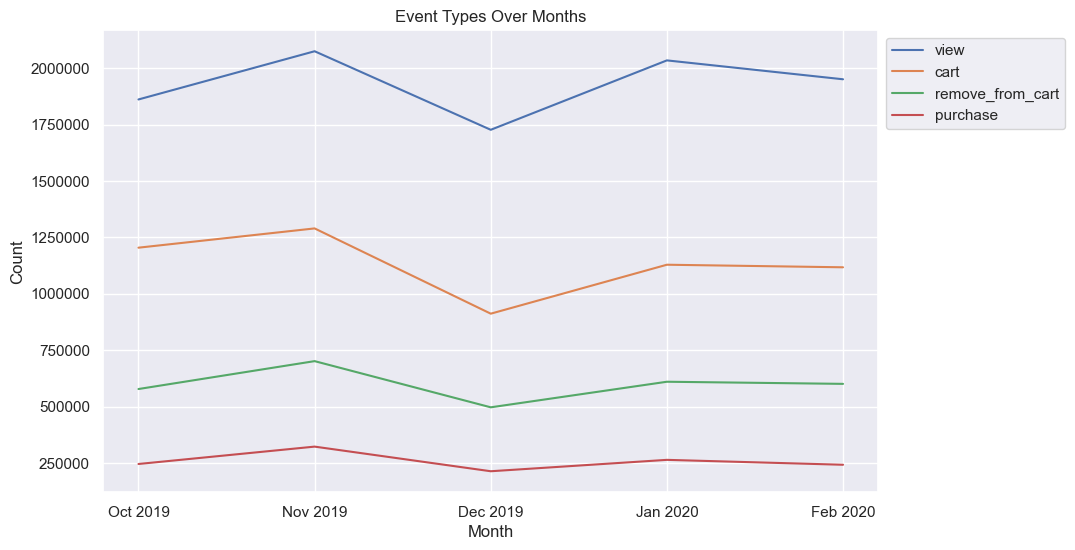

In [10]:
plt.figure(figsize= (10, 6))
for column in event_type_by_month.columns:
    plt.plot(event_type_by_month.index, event_type_by_month[column], label= column)

plt.title('Event Types Over Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.ticklabel_format(style= 'plain', axis= 'y') #禁用y軸ㄉ科學記號
plt.legend(loc= 'upper left', bbox_to_anchor= (1, 1))
plt.grid(True)
plt.show()

四種消費者行為的趨勢基本相符，值得注意的是12月有明顯低谷。

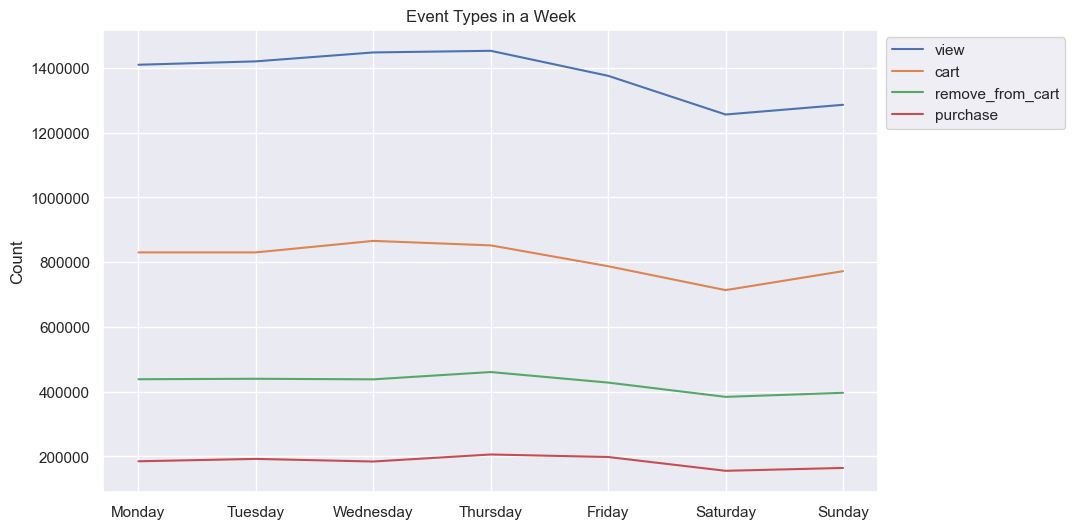

In [11]:
week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['weekday'] = pd.Categorical(data['weekday'], categories= week_order, ordered= True)

event_type_by_weekday = data.groupby('weekday')['event_type'].value_counts().unstack()
plt.figure(figsize= (10, 6))
for column in event_type_by_weekday.columns:
    plt.plot(event_type_by_weekday.index, event_type_by_weekday[column], label= column)

plt.title('Event Types in a Week')
plt.ylabel('Count')
plt.ticklabel_format(style= 'plain', axis= 'y') #禁用y軸ㄉ科學記號
plt.legend(loc= 'upper left', bbox_to_anchor= (1, 1))
plt.grid(True)
plt.show()

蠻讓人意外的是假日沒有比較高。

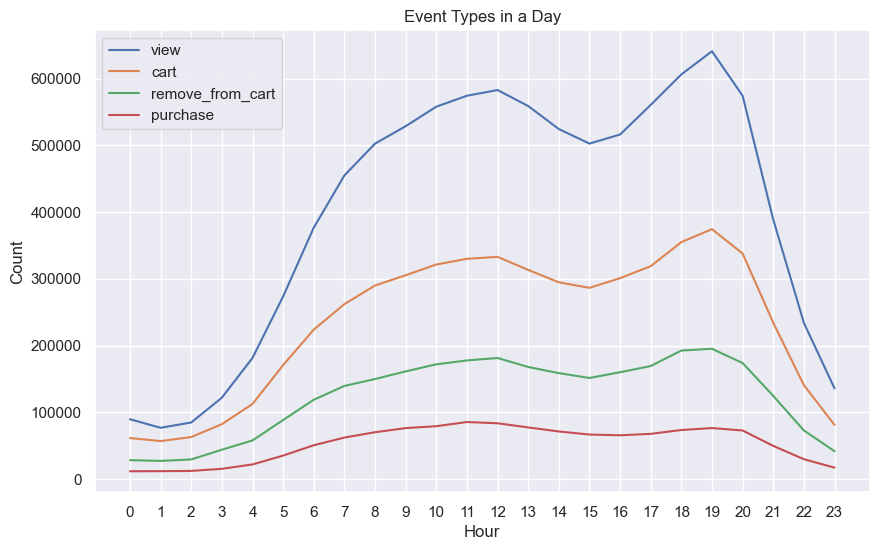

In [12]:
event_type_by_hour = data.groupby('hr')['event_type'].value_counts().unstack()
plt.figure(figsize= (10, 6))
for column in event_type_by_hour.columns:
    plt.plot(event_type_by_hour.index, event_type_by_hour[column], label=column)
plt.title('Event Types in a Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(event_type_by_hour.index)
plt.ticklabel_format(style= 'plain', axis= 'y') #禁用y軸ㄉ科學記號
plt.legend()
plt.grid(True)
plt.show()

日內的消費者行為統計形成一個雙峰結構，發生在中午12點以及晚上7點，正好是兩個休息時間。

### Sales Revenue

In [13]:
purchase_data = data[data['event_type']== 'purchase'] #首先指定purchase_data濾出消費者行為是購買的數據

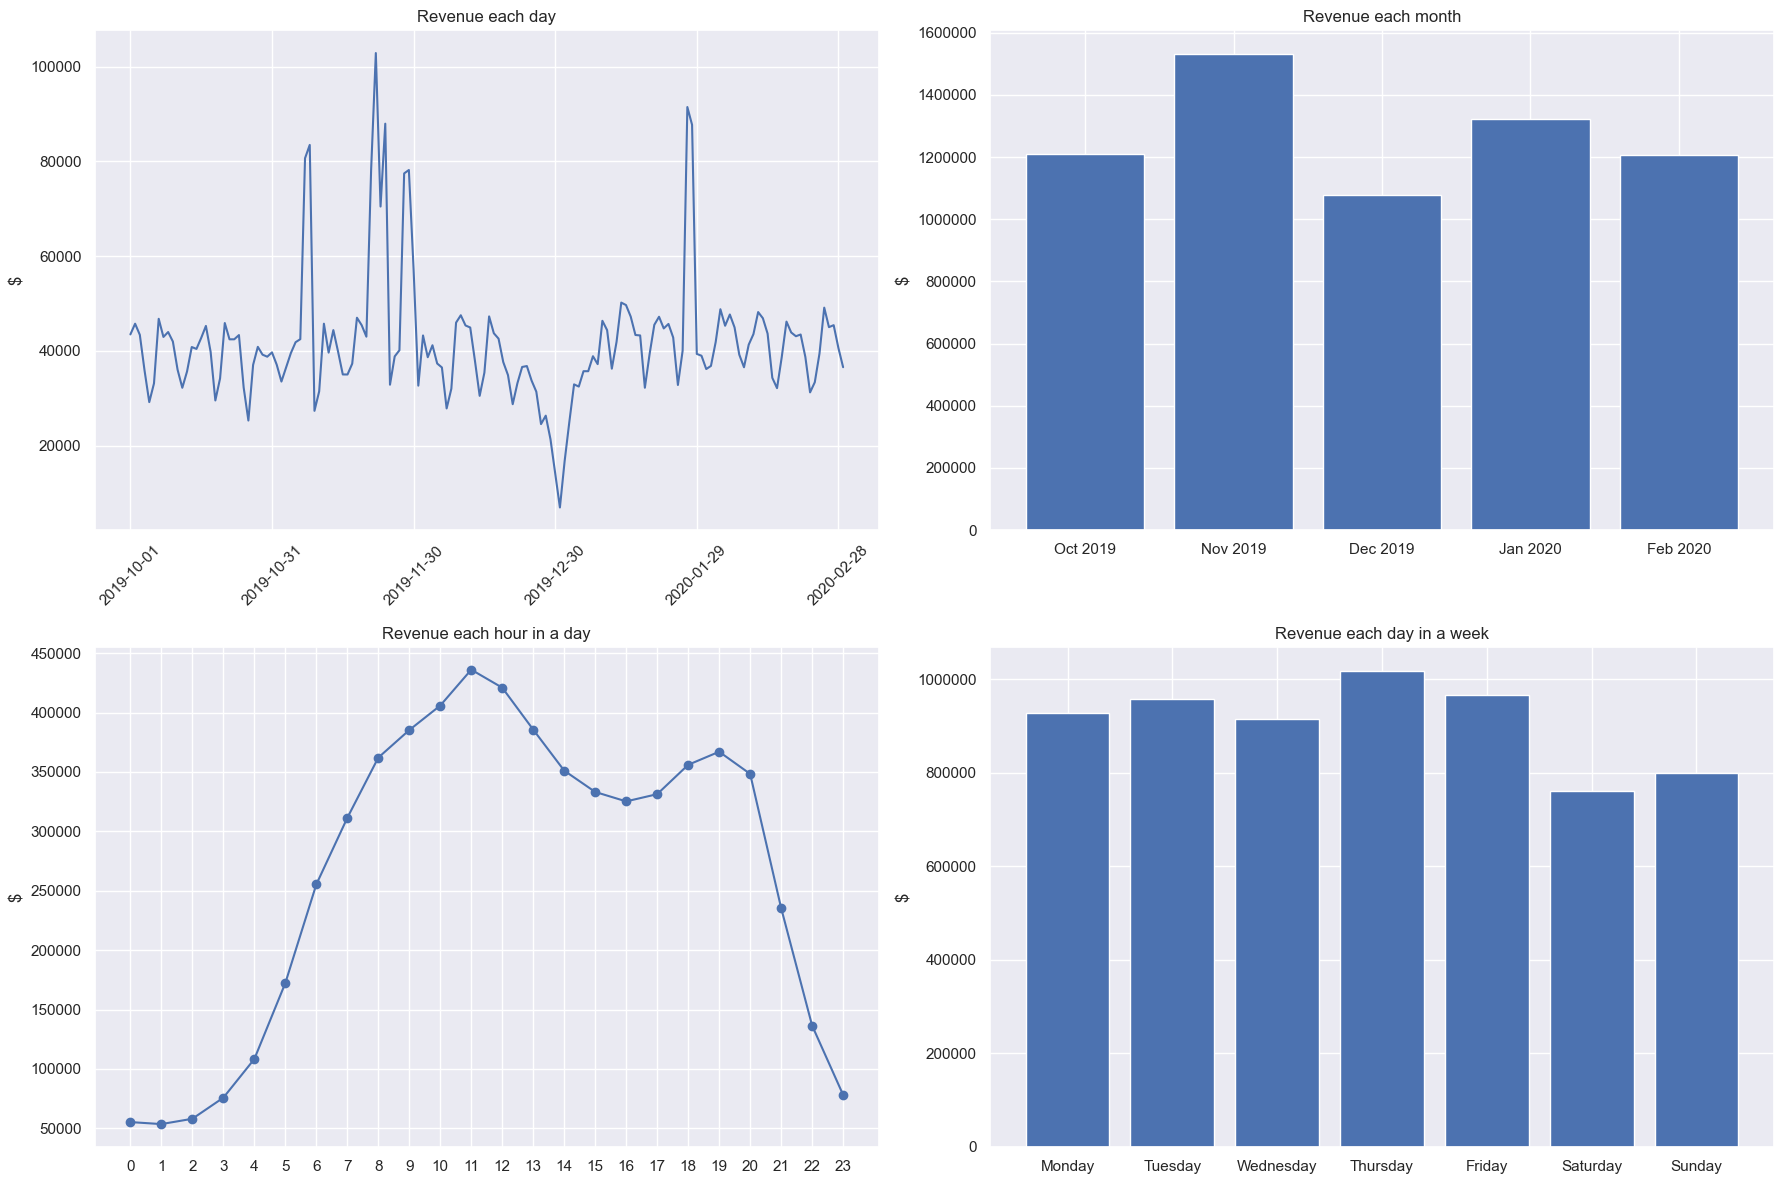

In [14]:
plt.figure(figsize= (18,12))

#Daily Revenue Amount
plt.subplot(2, 2, 1)
sales_per_day = purchase_data.groupby(['date'])['price'].sum()
plt.plot(sales_per_day)
plt.title('Revenue each day')
plt.ylabel('$')
selected_dates = sales_per_day.index[::30] #每30天為一間隔顯示避免x軸刻度擠在一起
plt.xticks(selected_dates, rotation= 45)  
plt.ticklabel_format(style= 'plain', axis= 'y') #禁用y軸ㄉ科學記號

# Sales by Month
plt.subplot(2, 2, 2)
sales_by_month = purchase_data.groupby(['month'])['price'].sum()
plt.bar(sales_by_month.index, sales_by_month)
plt.title('Revenue each month')
plt.ylabel('$')
plt.ticklabel_format(style= 'plain', axis= 'y')#禁用y軸ㄉ科學記號

#Sales in a Day
plt.subplot(2, 2, 3)
sales_by_hour = purchase_data.groupby(['hr'])['price'].sum()
plt.plot(sales_by_hour, marker= 'o')
plt.title('Revenue each hour in a day')
plt.ylabel('$')
plt.xticks(sales_by_hour.index)
plt.ticklabel_format(style= 'plain', axis= 'y') #禁用y軸ㄉ科學記號

# Sales by Weekday
plt.subplot(2, 2, 4)
sales_by_weekday = purchase_data.groupby(['weekday'])['price'].sum()
plt.bar(sales_by_weekday.index, sales_by_weekday)
plt.title('Revenue each day in a week')
plt.ylabel('$')
plt.ticklabel_format(style= 'plain', axis= 'y')#禁用y軸ㄉ科學記號

plt.tight_layout()
plt.show()


和前述消費者行為分析相似，12月產生的銷售額最少。  
中午11點和晚上7點同屬高峰，不過中午時段的銷售額明顯更高。對比上面的消費者行為，可以發現儘管晚上的瀏覽人次較多，但卻沒有導致較高銷售額產生。

### Product

In [15]:
top_products = purchase_data.groupby('product_id')['price'].sum().sort_values(ascending=False)
total_sales = purchase_data['price'].sum()
products_sales_percentage = (top_products / total_sales) 

C:\Users\arthu\AppData\Local\Temp\ipykernel_5692\3928996927.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])


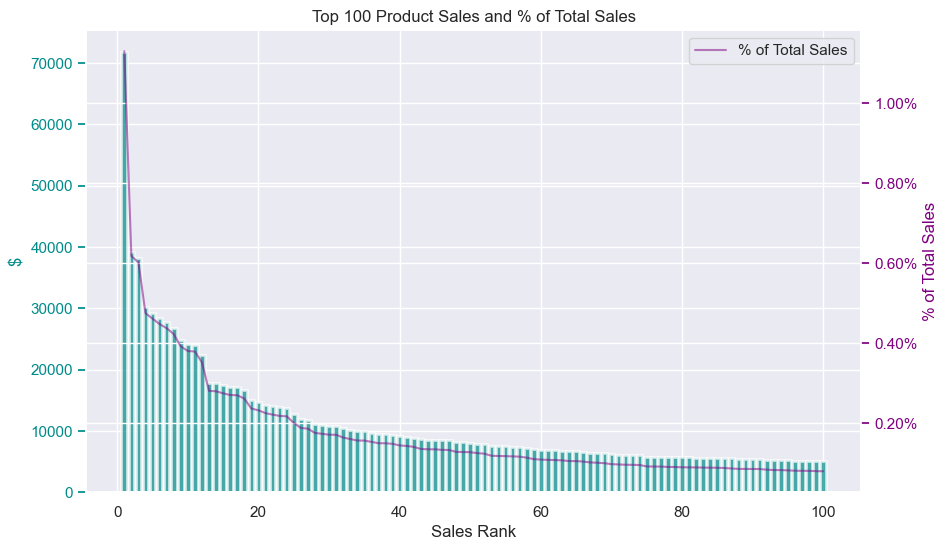

In [16]:
top100_products = top_products.head(100)
top100_products_sales_percentage = products_sales_percentage.head(100)

fig, ax1 = plt.subplots(figsize=(10, 6))

#Salesrevenue
ax1.bar(range(1, 101), top100_products.values, color= 'darkcyan', alpha=0.7, linewidth=2)
ax1.set_xlabel('Sales Rank')
ax1.set_ylabel('$', color='darkcyan')
ax1.tick_params('y', colors='darkcyan')

# % of Total Sales
ax2 = ax1.twinx()
ax2.plot(range(1, 101), top100_products_sales_percentage, color= 'purple', label= '% of Total Sales', alpha=0.5)
ax2.set_ylabel('% of Total Sales', color= 'purple')
ax2.tick_params('y', colors='purple')
ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])

plt.title('Top 100 Product Sales and % of Total Sales')
plt.legend()
plt.show()


C:\Users\arthu\AppData\Local\Temp\ipykernel_5692\1418054539.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])


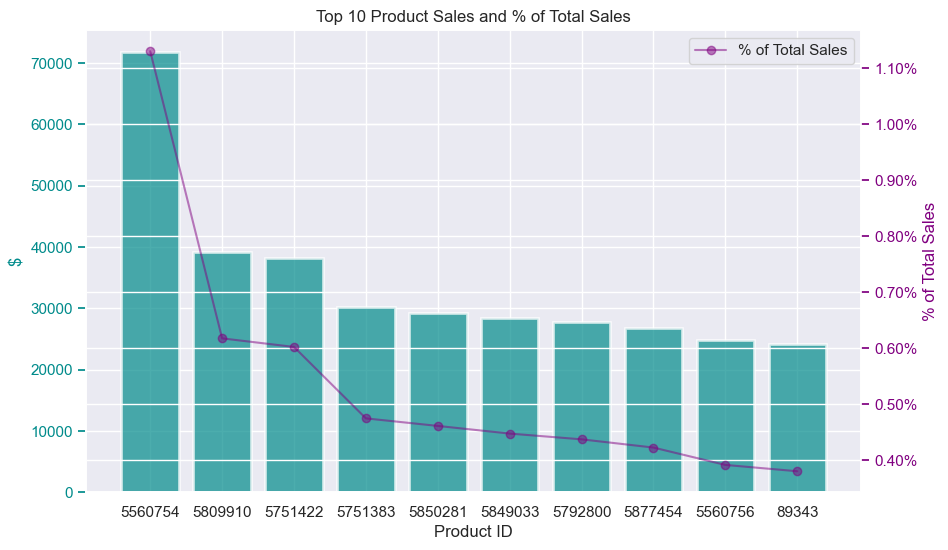

In [17]:
top10_products = top_products.head(10)
top10_products.index = top10_products.index.astype(str)
top10_products_sales_percentage = products_sales_percentage.head(10)
top10_products_sales_percentage.index = top10_products_sales_percentage.index.astype(str)
fig, ax1 = plt.subplots(figsize= (10, 6))

# Sales revenue
ax1.bar(top10_products.index, top10_products.values, color= 'darkcyan', alpha= 0.7, linewidth= 2)
ax1.set_xlabel('Product ID')
ax1.set_ylabel('$', color='darkcyan')
ax1.tick_params('y', colors='darkcyan')


# % of Total Sales
ax2 = ax1.twinx()
ax2.plot(top10_products_sales_percentage.index, top10_products_sales_percentage.values, marker='o', color= 'purple', label='% of Total Sales', alpha= 0.5)
ax2.set_ylabel('% of Total Sales', color= 'purple')
ax2.tick_params('y', colors= 'purple')
ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])

plt.title('Top 10 Product Sales and % of Total Sales')
plt.legend()
plt.show()

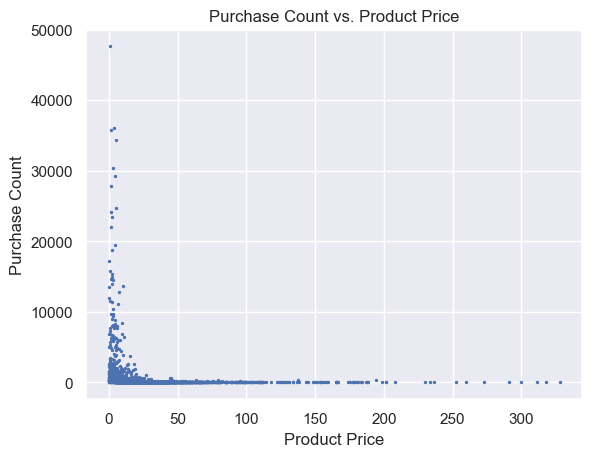

In [18]:
#Product_price and Frequency
product_price = purchase_data['price'].value_counts().sort_index()
plt.scatter(product_price.index, product_price.values, s= 2)
plt.title('Purchase Count vs. Product Price')
plt.xlabel('Product Price')
plt.ylabel('Purchase Count')
plt.show()

基本符合預想，大多數的商品集中在單價0-100，單價超過50後的商品購買次數都不高。

## Category

In [19]:
top_categories = purchase_data.groupby('category_id')['price'].sum().sort_values(ascending= False) 
categories_sales_percentage = (top_categories / total_sales) #用上面Product那邊定義好的total sales

C:\Users\arthu\AppData\Local\Temp\ipykernel_5692\2624437881.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])


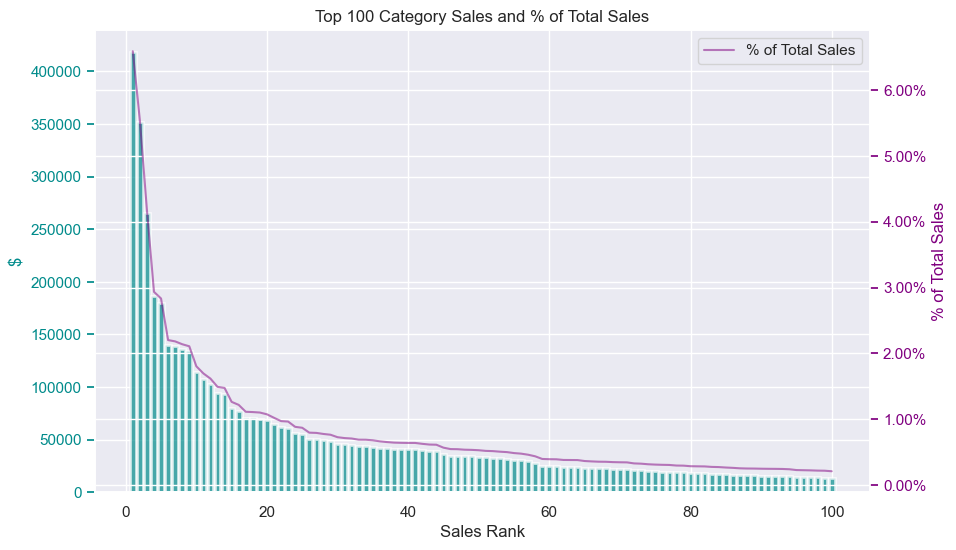

In [20]:
top100_categories = top_categories.head(100)
top100_categories_sales_percentage = categories_sales_percentage.head(100)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Sales revenue
ax1.bar(range(1, 101), top100_categories.values, color= 'darkcyan', alpha= 0.7, linewidth= 2)
ax1.set_xlabel('Sales Rank')
ax1.set_ylabel('$', color='darkcyan')
ax1.tick_params('y', colors='darkcyan')

# % of Total Sales
ax2 = ax1.twinx()
ax2.plot(range(1, 101), top100_categories_sales_percentage, color= 'purple', label= '% of Total Sales', alpha= 0.5)
ax2.set_ylabel('% of Total Sales', color= 'purple')
ax2.tick_params('y', colors= 'purple')
ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])

plt.title('Top 100 Category Sales and % of Total Sales')
plt.legend()
plt.show()

In [21]:
top10_categories = top_categories.head(10)
top10_categories.index = top10_categories.index.astype(str)
top10_categories_sales_percentage = categories_sales_percentage.head(10)
top10_categories_sales_percentage.index = top10_categories_sales_percentage.index.astype(str)

C:\Users\arthu\AppData\Local\Temp\ipykernel_5692\4052768476.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(top10_categories.index, rotation= 45, fontsize= 8)
C:\Users\arthu\AppData\Local\Temp\ipykernel_5692\4052768476.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])


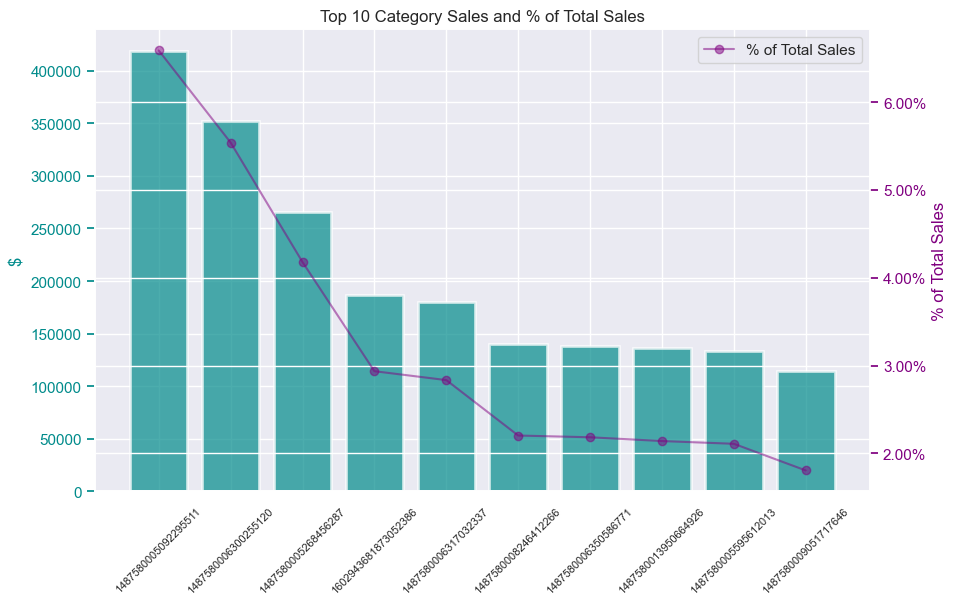

In [22]:
fig, ax1 = plt.subplots(figsize =(10, 6))

# Sales revenue
ax1.bar(top10_categories.index, top10_categories.values, color= 'darkcyan', alpha =0.7, linewidth= 2)
ax1.set_ylabel('$', color= 'darkcyan')
ax1.tick_params('y', colors= 'darkcyan')
ax1.set_xticklabels(top10_categories.index, rotation= 45, fontsize= 8)

# % of Total Sales
ax2 = ax1.twinx()
ax2.plot(top10_categories_sales_percentage.index, top10_categories_sales_percentage.values, marker= 'o', color= 'purple', label= '% of Total Sales', alpha= 0.5)
ax2.set_ylabel('% of Total Sales', color= 'purple')
ax2.tick_params('y', colors= 'purple')
ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])


plt.title('Top 10 Category Sales and % of Total Sales')
plt.legend()
plt.show()

### Brand

In [23]:
top_brand = purchase_data.groupby('brand')['price'].sum().sort_values(ascending=False) 
brand_sales_percentage = (top_brand / total_sales) #用上面Product那邊定義好的total sales

C:\Users\arthu\AppData\Local\Temp\ipykernel_5692\2695027026.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])


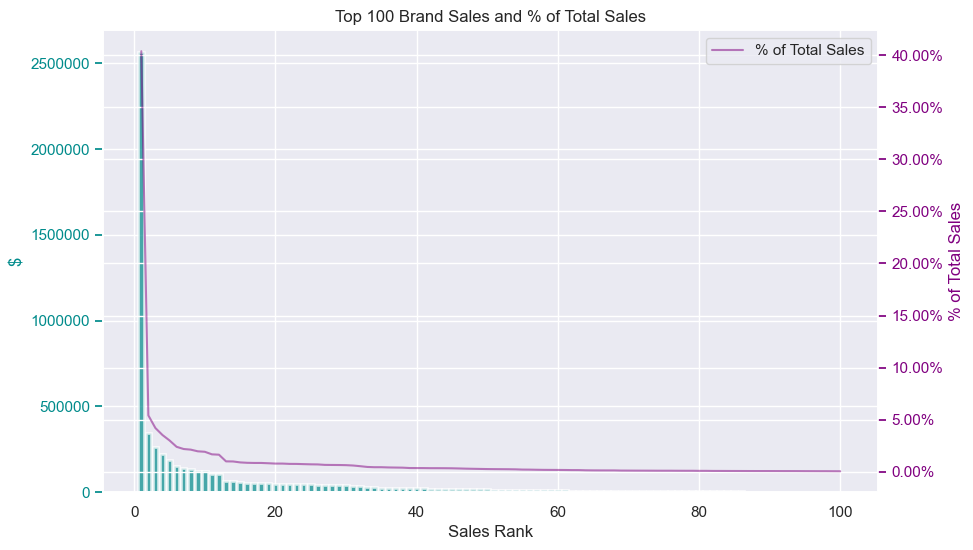

In [24]:
top100_brand = top_brand.head(100)
top100_brand_sales_percentage = brand_sales_percentage.head(100)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Sales revenue
ax1.bar(range(1, 101), top100_brand.values, color= 'darkcyan', alpha=0.7, linewidth= 2)
ax1.set_xlabel('Sales Rank')
ax1.set_ylabel('$', color='darkcyan')
ax1.tick_params('y', colors='darkcyan')
ax1.ticklabel_format(style= 'plain', axis= 'y')#禁用y軸ㄉ科學記號
# % of Total Sales
ax2 = ax1.twinx()
ax2.plot(range(1, 101), top100_brand_sales_percentage, color='purple', label='% of Total Sales', alpha= 0.5)
ax2.set_ylabel('% of Total Sales', color= 'purple')
ax2.tick_params('y', colors= 'purple')
ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])


plt.title('Top 100 Brand Sales and % of Total Sales')
plt.legend()
plt.show()

第一名非常高，但考量先前資料處理時我們將非常多的NaN值轉成了Unknown，因此這邊第一名應該就是他。

In [25]:
top10_brand = top_brand.head(10)
top10_brand.index = top10_brand.index.astype(str)
top10_brand_sales_percentage = brand_sales_percentage.head(10)
top10_brand_sales_percentage.index = top10_brand_sales_percentage.index.astype(str)

C:\Users\arthu\AppData\Local\Temp\ipykernel_5692\489462945.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(top10_brand.index, rotation= 45)
C:\Users\arthu\AppData\Local\Temp\ipykernel_5692\489462945.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])


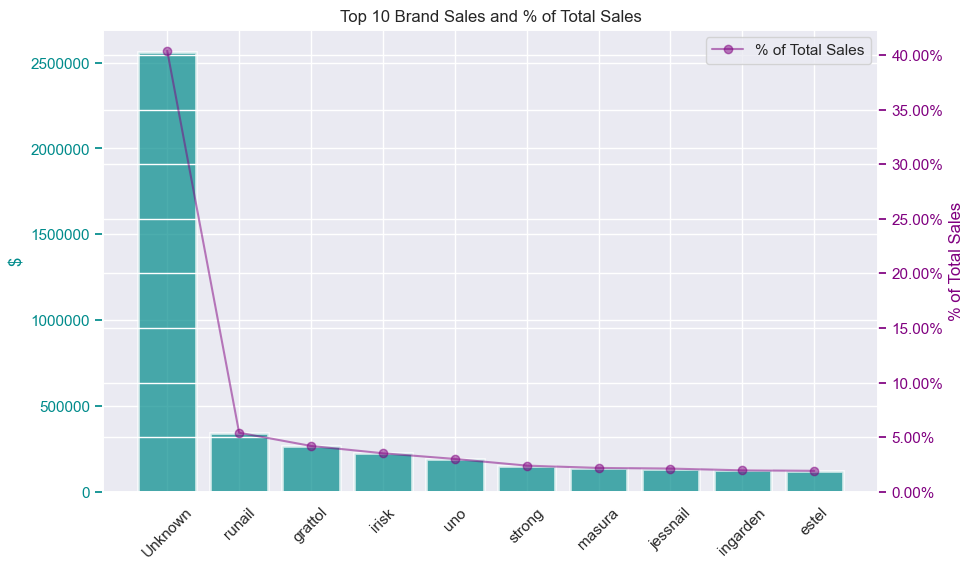

In [26]:
fig, ax1 = plt.subplots(figsize = (10, 6))

# Sales revenue
ax1.bar(top10_brand.index, top10_brand.values, color= 'darkcyan', alpha= 0.7, linewidth=2)
ax1.set_ylabel('$', color= 'darkcyan')
ax1.tick_params('y', colors= 'darkcyan')
ax1.set_xticklabels(top10_brand.index, rotation= 45)
ax1.ticklabel_format(style= 'plain', axis= 'y')#禁用y軸ㄉ科學記號
# % of Total Sales
ax2 = ax1.twinx()
ax2.plot(top10_brand_sales_percentage.index, top10_brand_sales_percentage.values, marker= 'o', color= 'purple', label= '% of Total Sales', alpha= 0.5)
ax2.set_ylabel('% of Total Sales', color= 'purple')
ax2.tick_params('y', colors= 'purple')
ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])

plt.title('Top 10 Brand Sales and % of Total Sales')
plt.legend()
plt.show()

C:\Users\arthu\AppData\Local\Temp\ipykernel_5692\1105552203.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(top10_brand.index[1:], rotation=45, fontsize=8)
C:\Users\arthu\AppData\Local\Temp\ipykernel_5692\1105552203.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])


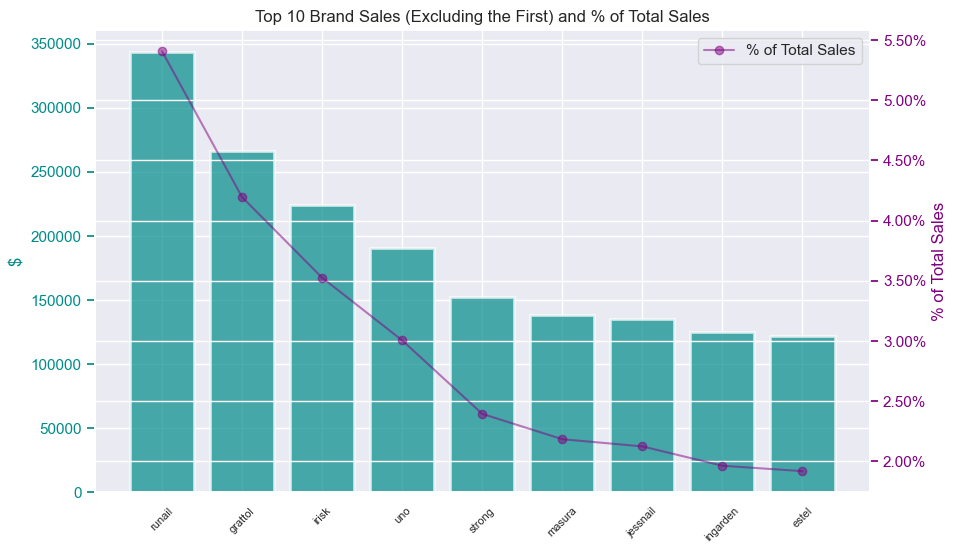

In [27]:
#排除Unkwon後
fig, ax1 = plt.subplots(figsize =(10, 6))

# Sales revenue
ax1.bar(top10_brand.index[1:], top10_brand.values[1:], color='darkcyan', alpha=0.7, linewidth=2)
ax1.set_ylabel('$', color='darkcyan')
ax1.tick_params('y', colors='darkcyan')
ax1.set_xticklabels(top10_brand.index[1:], rotation=45, fontsize=8)
ax1.ticklabel_format(style='plain', axis='y')  # 禁用y軸ㄉ科學記號

# % of Total Sales
ax2 = ax1.twinx()
ax2.plot(top10_brand_sales_percentage.index[1:], top10_brand_sales_percentage.values[1:], marker= 'o', color= 'purple',
         label= '% of Total Sales', alpha= 0.5)
ax2.set_ylabel('% of Total Sales', color='purple')
ax2.tick_params('y', colors='purple')
ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])

plt.title('Top 10 Brand Sales (Excluding the First) and % of Total Sales')
plt.legend()
plt.show()

### User

In [28]:
active_user_count = data.groupby('date')['user_id'].nunique()#不計算重複的使用者
daily_revenue = purchase_data.groupby('date')['price'].sum()# Daily Revenue 和 avg revenue per User
average_revenue_per_user = daily_revenue / active_user_count
selected_dates = sales_per_day.index[::10] #x軸刻度間距設個10天

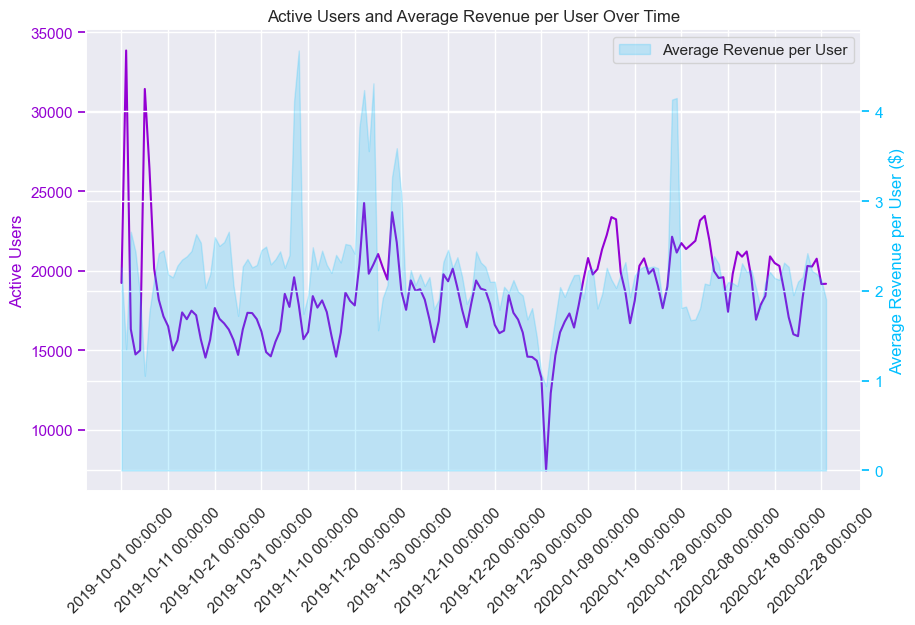

In [29]:
fig, ax1 = plt.subplots(figsize=(10, 6))

#unique cust數量
ax1.plot(active_user_count, label='Active Users', color='darkviolet')
ax1.set_ylabel('Active Users', color='darkviolet')
ax1.tick_params('y', colors='darkviolet')
ax1.set_xticks(selected_dates)
ax1.set_xticklabels(selected_dates, rotation=45)
ax1.ticklabel_format(style='plain', axis='y')  # Disable y-axis scientific notation

# Avg Rev/user
ax2 = ax1.twinx()
ax2.fill_between(average_revenue_per_user.index, average_revenue_per_user, color= 'deepskyblue', alpha= 0.2, label= 'Average Revenue per User')
ax2.set_ylabel('Average Revenue per User ($)', color= 'deepskyblue')
ax2.tick_params('y', colors='deepskyblue')
ax2.grid(True)

plt.title('Active Users and Average Revenue per User Over Time')
plt.legend()
plt.show()

In [30]:
# Top100 User by Revenue
users_revenue = purchase_data.groupby('user_id')['price'].sum().sort_values(ascending= False)
users_sales_percentage = (users_revenue / total_sales)
top100_users = users_revenue.head(100)
top100_users_sales_percentage = users_sales_percentage.head(100)

C:\Users\arthu\AppData\Local\Temp\ipykernel_5692\1964666836.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])


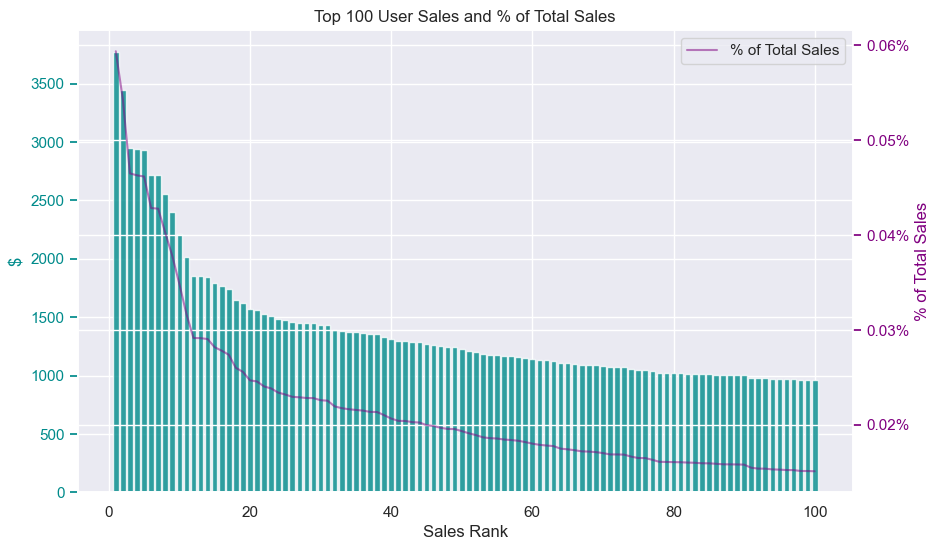

In [31]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Sales revenue
ax1.bar(range(1, 101), top100_users.values, color='darkcyan', alpha=0.8)
ax1.set_xlabel('Sales Rank')
ax1.set_ylabel('$', color='darkcyan')
ax1.tick_params('y', colors='darkcyan')

# % of Total Sales
ax2 = ax1.twinx()
ax2.plot(range(1, 101), top100_users_sales_percentage, color='purple', label='% of Total Sales', alpha=0.5)
ax2.set_ylabel('% of Total Sales', color='purple')
ax2.tick_params('y', colors='purple')
ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])

plt.title('Top 100 User Sales and % of Total Sales')
plt.legend()
plt.show()

C:\Users\arthu\AppData\Local\Temp\ipykernel_5692\2570118052.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(top10_users.index, rotation= 45)
C:\Users\arthu\AppData\Local\Temp\ipykernel_5692\2570118052.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])


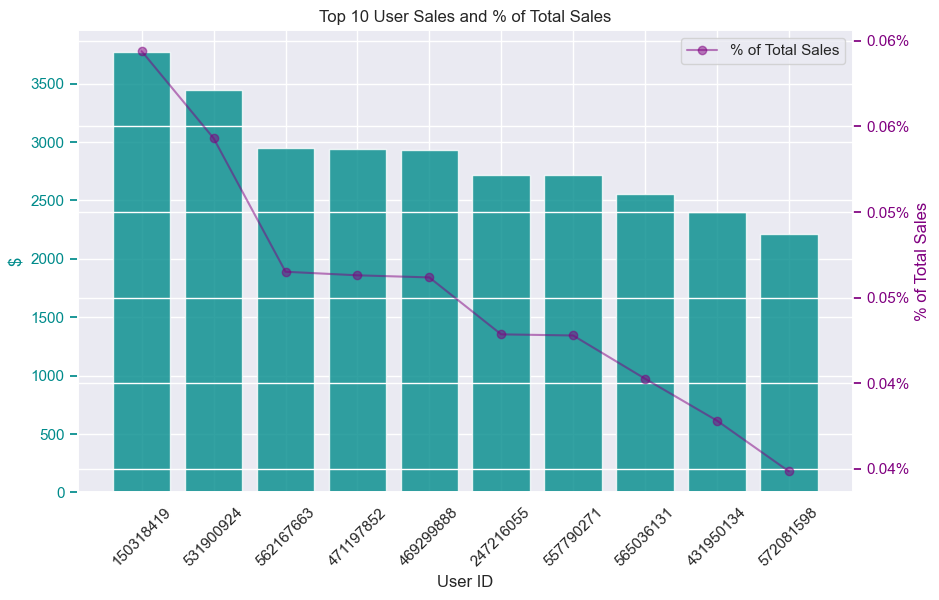

In [32]:
top10_users = users_revenue.head(10)
top10_users_sales_percentage = users_sales_percentage.head(10)

fig, ax1 = plt.subplots(figsize= (10, 6))
# Sales revenue
ax1.bar(top10_users.index.astype(str), top10_users.values, color= 'darkcyan', alpha= 0.8)
ax1.set_xlabel('User ID')
ax1.set_ylabel('$', color= 'darkcyan')
ax1.tick_params('y', colors= 'darkcyan')
ax1.set_xticklabels(top10_users.index, rotation= 45)
# % of Total Sales
ax2 = ax1.twinx()
ax2.plot(top10_users.index.astype(str), top10_users_sales_percentage, marker= 'o', color= 'purple', label= '% of Total Sales', alpha= 0.5)
ax2.set_ylabel('% of Total Sales', color= 'purple')
ax2.tick_params('y', colors= 'purple')
ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])

plt.title('Top 10 User Sales and % of Total Sales')
plt.legend()
plt.show()


## E- commerce KPI
PV: Page Views  
UV：Unique Visitor (User)  
UV/PV：平均每位訪客查看了多少頁面  
purchase conversion rate：瀏覽頁面有購買的比例  
purchase user%：有完成購買的用戶比例

In [33]:
# 根據日期進行分組，計算數據，先計算pv和uv
view_data= data[data['event_type']== 'view']
daily_pv = view_data.groupby(data['date'])['user_id'].size() 
daily_uv= view_data.groupby(data['date'])['user_id'].nunique()
daily_data = pd.concat([daily_pv, daily_uv], axis=1)
daily_data.columns =['pv', 'uv']
daily_data['pv/uv'] = daily_data['pv'] / daily_data['uv']
#再計算購買轉化率和
daily_data['purchase_count']= purchase_data.groupby('date').size()
daily_data['purchase_conversion_rate'] =  daily_data['purchase_count'] / daily_data['pv'] # view to purchase
daily_data['purchase_user']= purchase_data.groupby('date')['user_id'].nunique()
daily_data['purchase user %'] = daily_data['purchase_user'] / daily_data['uv'] #purchase user %
daily_data.head()


,pv,uv,pv/uv,purchase_count,purchase_conversion_rate,purchase_user,purchase user %
date,,,,,,,
2019-10-01,61185,18392,3.327,8466,0.138,1001,0.054
2019-10-02,76465,32954,2.320,9098,0.119,1045,0.032
2019-10-03,56913,15468,3.679,8856,0.156,1048,0.068
2019-10-04,53661,13932,3.852,7560,0.141,892,0.064
2019-10-05,49400,14320,3.450,5933,0.120,708,0.049


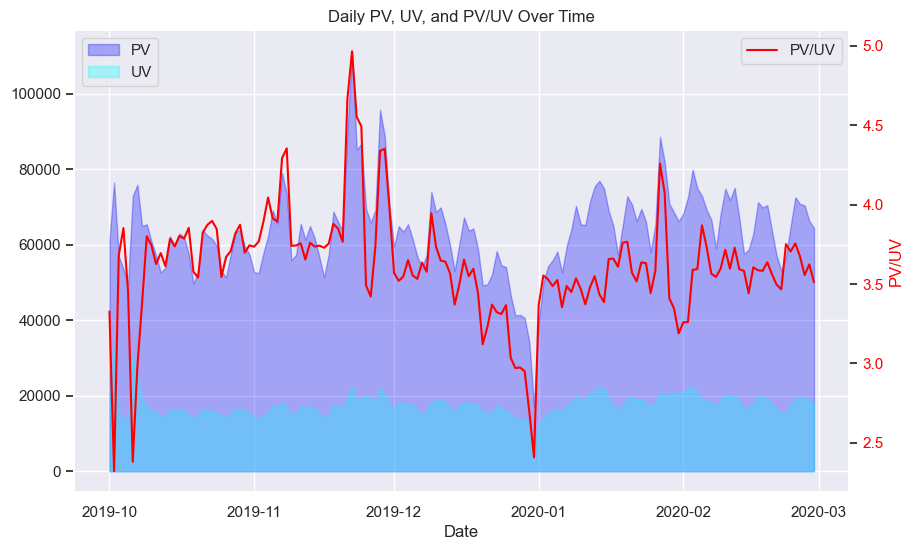

In [34]:
fig, ax1 = plt.subplots(figsize= (10, 6))

ax1.fill_between(daily_data.index, daily_data['pv'], label= 'PV', color= 'blue', alpha=0.3)
ax1.fill_between(daily_data.index, daily_data['uv'], label= 'UV', color= 'cyan', alpha=0.3)
ax1.set_xlabel('Date')
ax1.legend(loc= 'upper left')

# 次坐標軸
ax2 = ax1.twinx()
ax2.plot(daily_data.index, daily_data['pv/uv'], label= 'PV/UV', color= 'red')
ax2.set_ylabel('PV/UV', color= 'red')
ax2.tick_params(axis= 'y', labelcolor= 'red')
ax2.legend(loc= 'upper right')
ax2.grid(False)

plt.title('Daily PV, UV, and PV/UV Over Time')
plt.show()


C:\Users\arthu\AppData\Local\Temp\ipykernel_5692\2245929130.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ax2.get_yticks()])


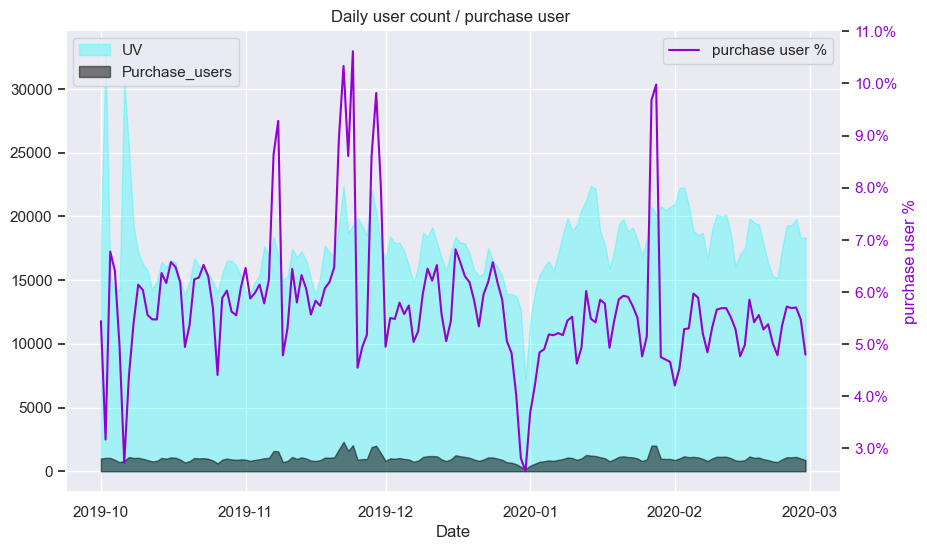

In [35]:
fig, ax1 = plt.subplots(figsize= (10, 6))

ax1.fill_between(daily_data.index, daily_data['uv'], label= 'UV', color= 'cyan', alpha=0.3)
ax1.fill_between(daily_data.index, daily_data['purchase_user'], label= 'Purchase_users', color= 'black', alpha=0.5)
ax1.set_xlabel('Date')
ax1.legend(loc= 'upper left')

ax2 = ax1.twinx()
ax2.plot(daily_data.index, daily_data['purchase user %'], label= 'purchase user %', color= 'darkviolet')
ax2.set_ylabel('purchase user %', color= 'darkviolet')
ax2.tick_params(axis= 'y', labelcolor= 'darkviolet')
ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ax2.get_yticks()])
ax2.legend(loc= 'upper right')
ax2.grid(False)

plt.title('Daily user count / purchase user ')
plt.show()

C:\Users\arthu\AppData\Local\Temp\ipykernel_5692\86855236.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ax2.get_yticks()])


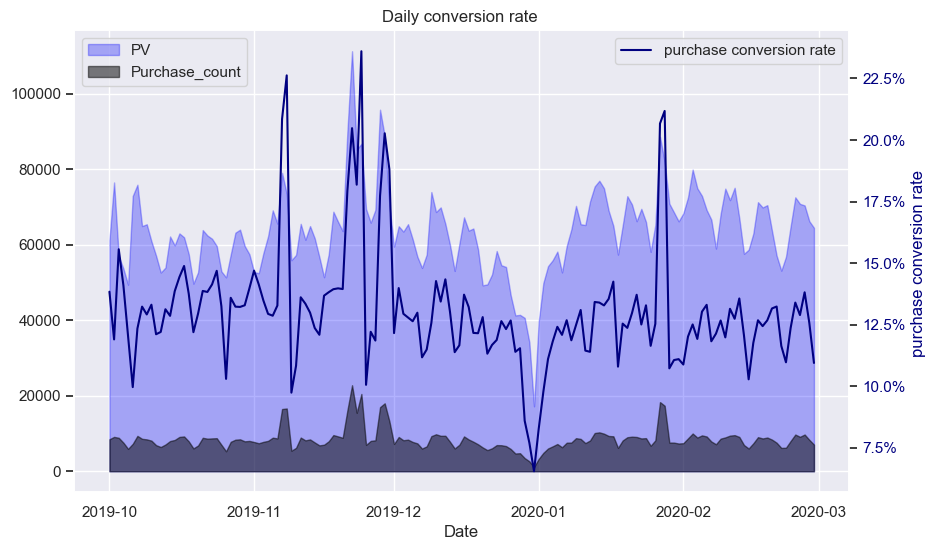

In [36]:
fig, ax1 = plt.subplots(figsize= (10, 6))

ax1.fill_between(daily_data.index, daily_data['pv'], label= 'PV', color= 'blue', alpha= 0.3)
ax1.fill_between(daily_data.index, daily_data['purchase_count'], label= 'Purchase_count', color= 'black', alpha= 0.5)
ax1.set_xlabel('Date')
ax1.legend(loc= 'upper left')

ax2 = ax1.twinx()
ax2.plot(daily_data.index, daily_data['purchase_conversion_rate'], label= 'purchase conversion rate', color= 'navy')
ax2.set_ylabel('purchase conversion rate ', color= 'navy')
ax2.tick_params(axis= 'y', labelcolor= 'navy')
ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ax2.get_yticks()])
ax2.legend(loc= 'upper right')
ax2.grid(False)

plt.title('Daily conversion rate ')
plt.show()

### 二八法則
看看這份數據是否遵循二八法則，即前20%的因素影響80%的結果。 

In [37]:
top_20_percent_products = products_sales_percentage.head(int(len(products_sales_percentage)* 0.2))
# 計算排名前20%的商品佔總銷售額的比例
top_20_percent_sales_percentage = top_20_percent_products.sum()
print("排名前20%的商品佔總銷售額的比例： {:.2f}%".format(top_20_percent_sales_percentage*100))

top_20_percent_categories = categories_sales_percentage.head(int(len(categories_sales_percentage)* 0.2))
# 計算排名前20%的商品佔總銷售額的比例
top_20_percent_categories_percentage= top_20_percent_categories.sum()
print("排名前20%的品類佔總銷售額的比例： {:.2f}%".format(top_20_percent_categories_percentage*100))

top_20_percent_brand =brand_sales_percentage.head(int(len(brand_sales_percentage)*0.2))
# 計算排名前20%的品牌佔總銷售額的比例
top_20_percent_brand_percentage =top_20_percent_brand.sum()
print("排名前20%的品牌佔總銷售額的比例： {:.2f}%".format(top_20_percent_brand_percentage*100))

排名前20%的商品佔總銷售額的比例： 80.03%
排名前20%的品類佔總銷售額的比例： 81.76%
排名前20%的品牌佔總銷售額的比例： 91.97%


品牌同樣須考量到數據包含很多Unknown，因此比較不具參考性，   
但在這麼多Unknoown的狀況下，前19大品牌(扣除Unknown)依然占有五成左右的占比，因此原始的資料狀況應該也和二八法則相去不遠。

## RSFM Model
在傳統的RFM模型上加上一個新的維度S(Siniority)，並且利用RSFM的結果來對客戶做KMeans集群分析。  
R：Recency : 最近一次購買  
S：Seniority：最早一次購買  
F：Frequency : 購買頻率  
M：Monetary : 消費均價    


In [38]:
data.head()

,event_time,event_type,product_id,category_id,brand,price,user_id,date,month,day,weekday,hr
0,2019-10-01 00:00:00,cart,5773203,1487580005134238553,runail,2.620,463240011,2019-10-01,Oct 2019,1,Tuesday,0
1,2019-10-01 00:00:03,cart,5773353,1487580005134238553,runail,2.620,463240011,2019-10-01,Oct 2019,1,Tuesday,0
2,2019-10-01 00:00:07,cart,5723490,1487580005134238553,runail,2.620,463240011,2019-10-01,Oct 2019,1,Tuesday,0
3,2019-10-01 00:00:07,cart,5881589,2151191071051219817,lovely,13.480,429681830,2019-10-01,Oct 2019,1,Tuesday,0
4,2019-10-01 00:00:15,cart,5881449,1487580013522845895,lovely,0.560,429681830,2019-10-01,Oct 2019,1,Tuesday,0


In [39]:
user_data = data.pivot_table(index='user_id', columns='event_type', aggfunc='size', fill_value=0)
#原本是用data.groupby('user_id')['event_type'].value_counts().unstack(fill_value= 0)，但是因為value_counts實在太低效要跑非常久，因此改用pivot_table

amount_df = purchase_data.groupby('user_id')['price'].sum().reset_index()
user_data = pd.merge(user_data, amount_df, on='user_id', how= 'left')
user_data.rename(columns={'price': 'amount',
                          'purchase': 'purchase_count',
                          'cart': 'cart_count',
                          'view': 'view_count',
                          'remove_from_cart': 'remove_from_cart_count'}, inplace=True)

user_data.fillna(0, inplace= True)

user_data.head()

,user_id,view_count,cart_count,remove_from_cart_count,purchase_count,amount
0,465496,3,0,0,0,0.000
1,1120748,1,0,0,0,0.000
2,1180452,1,0,0,0,0.000
3,1458813,31,0,0,0,0.000
4,2038666,1,0,0,0,0.000


In [40]:
user_data[user_data['purchase_count']!= 0]
#其實真的有消費紀錄的只有約11萬個

,user_id,view_count,cart_count,remove_from_cart_count,purchase_count,amount
20,9794320,93,56,33,4,12.680
21,10079204,0,2,0,2,25.810
24,10280338,133,209,117,86,177.830
31,12055855,10,7,0,4,16.540
32,12936739,2,5,0,2,29.890
...,...,...,...,...,...,...
1639042,622065819,4,12,7,4,20.480
1639052,622066161,13,10,6,4,12.950
1639086,622067983,16,31,16,10,66.480
1639109,622069477,1,37,0,1,0.950


In [41]:
#Recency 距離最近一次購買
r_df = purchase_data.groupby('user_id')['event_time'].max().reset_index()
r_df['recency'] =(data['event_time'].max() - r_df['event_time']).dt.days

#Seniority 距離最久一次購買
s_df = purchase_data.groupby('user_id')['event_time'].min().reset_index()
s_df['seniority'] =(data['event_time'].max() - s_df['event_time']).dt.days

#Frequency 消費頻率
f_df = purchase_data.groupby('user_id')['event_time'].count().reset_index()
f_df.columns =['user_id', 'frequency']

#Monetary 消費均價
m_df = purchase_data.groupby('user_id')['price'].mean().reset_index()
m_df.columns =['user_id', 'monetary']

rsfm_df = pd.merge(r_df[['user_id', 'recency']], s_df[['user_id', 'seniority']], on= 'user_id')
rsfm_df = pd.merge(rsfm_df, f_df, on= 'user_id')
rsfm_df = pd.merge(rsfm_df, m_df, on= 'user_id')

rsfm_df.head()

,user_id,recency,seniority,frequency,monetary
0,9794320,96,96,4,3.170
1,10079204,115,115,2,12.905
2,10280338,10,101,86,2.068
3,12055855,71,71,4,4.135
4,12936739,43,43,2,14.945


In [42]:
rsfm_df.shape

(110518, 5)

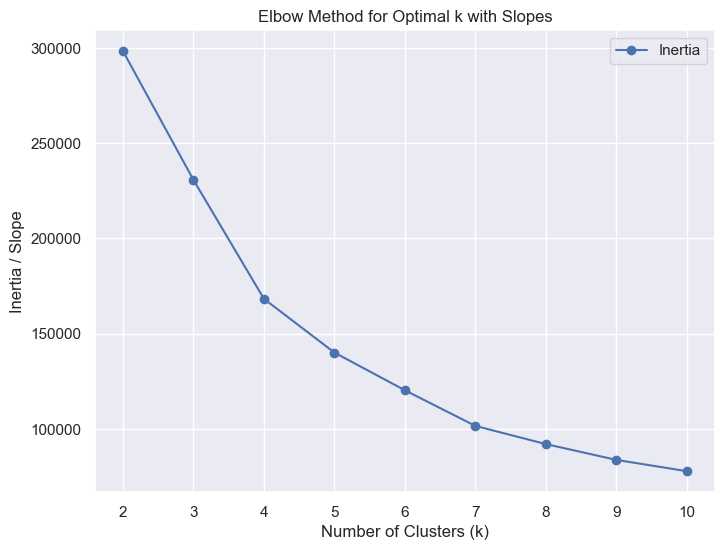

In [43]:
# 選擇要用於分群的特徵欄位
features = ['recency', 'seniority', 'frequency', 'monetary']
rsfm_df[features] = rsfm_df[features].apply(pd.to_numeric, errors='coerce')

# Scaled成-1到1
X = rsfm_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

#Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o', label='Inertia')
plt.title('Elbow Method for Optimal k with Slopes')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia / Slope')
plt.legend()
plt.show()

比較沒有非常明顯的肘部，大概落在4~6之間，我們選用5。

In [44]:
# KMeans Cluster
num_cluster = 5
kmeans = KMeans(n_clusters=num_cluster, random_state=11)
rsfm_df['cluster'] = kmeans.fit_predict(X_scaled)

#把縮放後的特徵也加進來
X_scaled_df = pd.DataFrame(X_scaled, columns=[f'{feature}_scaled' for feature in features])
rsfm_df = pd.concat([rsfm_df, X_scaled_df], axis=1)

rsfm_df.head()

,user_id,recency,seniority,frequency,monetary,cluster,recency_scaled,seniority_scaled,frequency_scaled,monetary_scaled
0,9794320,96,96,4,3.170,0,0.598,0.344,-0.418,-0.373
1,10079204,115,115,2,12.905,2,1.031,0.777,-0.528,0.364
2,10280338,10,101,86,2.068,1,-1.360,0.458,4.074,-0.456
3,12055855,71,71,4,4.135,0,0.029,-0.226,-0.418,-0.300
4,12936739,43,43,2,14.945,3,-0.609,-0.865,-0.528,0.518


In [45]:
rsfm_df.columns = ['user_id', 'r', 's', 'f', 'm', 'group', 'r_scaled', 's_scaled', 'f_scaled', 'm_scaled']
rsfm_df['group'] = rsfm_df['group'] + 1
rsfm_df.head()


,user_id,r,s,f,m,group,r_scaled,s_scaled,f_scaled,m_scaled
0,9794320,96,96,4,3.170,1,0.598,0.344,-0.418,-0.373
1,10079204,115,115,2,12.905,3,1.031,0.777,-0.528,0.364
2,10280338,10,101,86,2.068,2,-1.360,0.458,4.074,-0.456
3,12055855,71,71,4,4.135,1,0.029,-0.226,-0.418,-0.300
4,12936739,43,43,2,14.945,4,-0.609,-0.865,-0.528,0.518


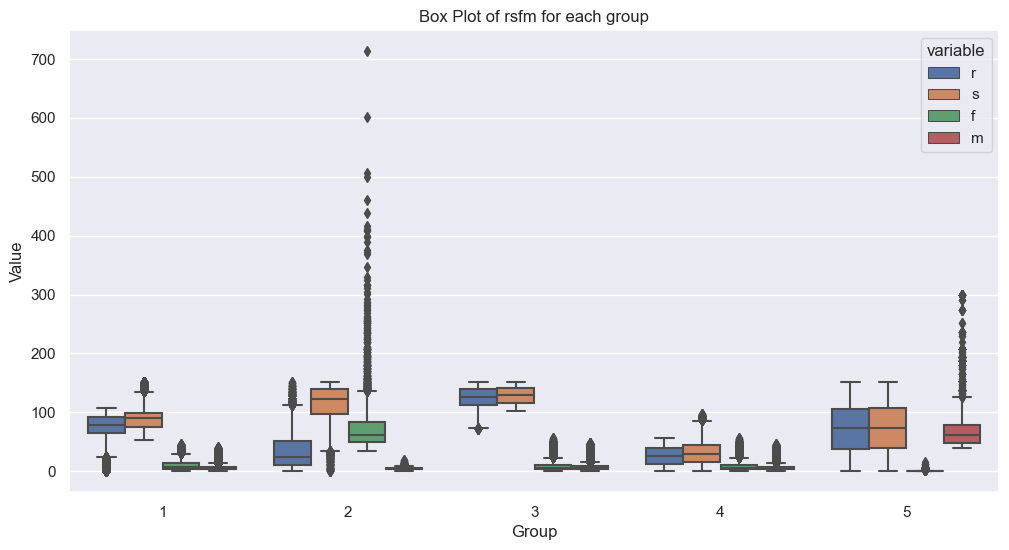

In [46]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='group', y='value', hue='variable', 
            data=pd.melt(rsfm_df, id_vars=['group'], 
                         value_vars=['r', 's', 'f', 'm']), ax=ax) 

ax.set(xlabel='Group', ylabel='Value')
ax.set_title('Box Plot of rsfm for each group')
plt.show()

有很多Outliers導致不是很好對比組間狀況，我們先暫時Disabled他們。

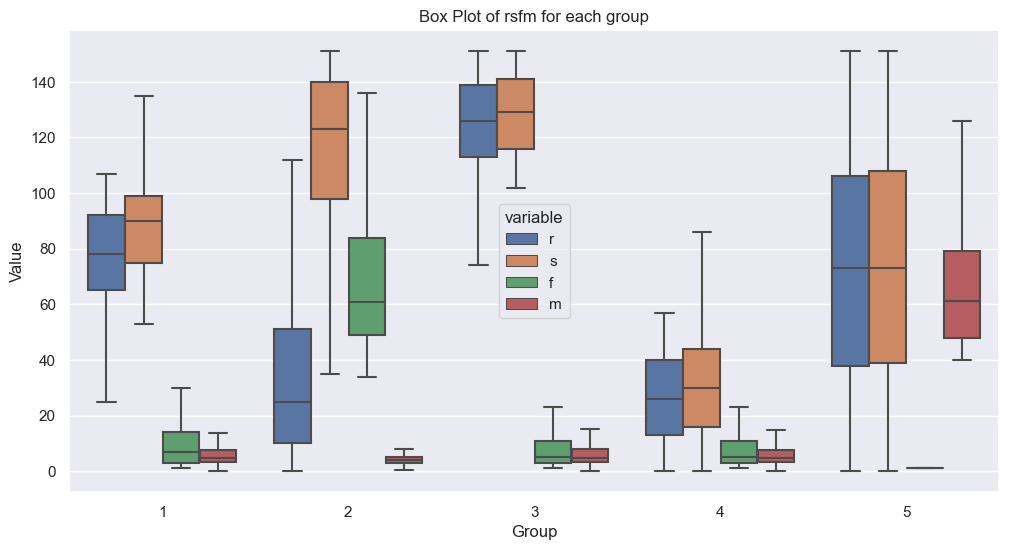

In [47]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(x='group', y='value', hue='variable', 
            data=pd.melt(rsfm_df, id_vars=['group'], 
                         value_vars=['r', 's', 'f', 'm']), 
            showfliers=False, ax=ax)  # 這裡禁止顯示異常值，如果需要可以移除這個參數


ax.set(xlabel='Group', ylabel='Value')
ax.set_title('Box Plot of rsfm for each group')
plt.show()

因為各種維度的比例問題，還是沒有辦法很好的觀察到各組狀況，因此我們使用Scaled過後的數據來看看。

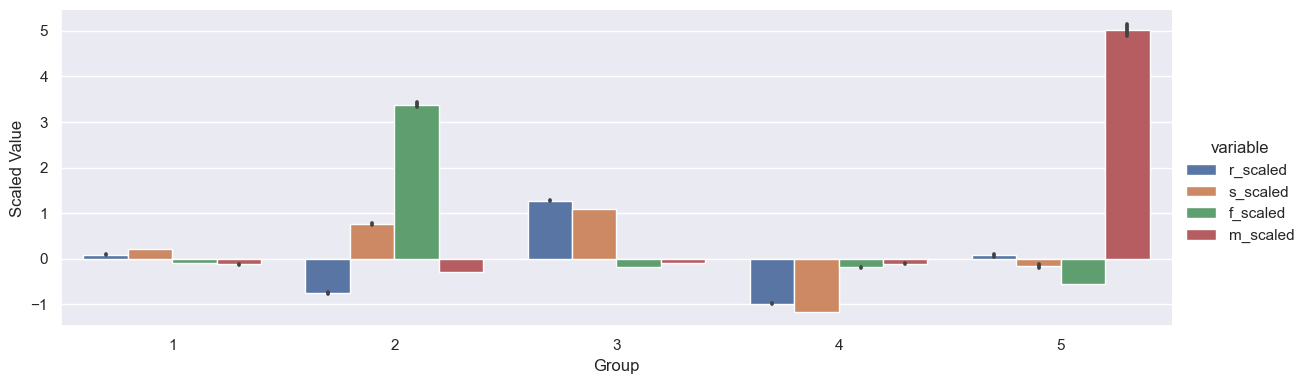

In [48]:
rsfmscaled = sns.catplot(x= 'group', y= 'value', hue= 'variable', 
                data=pd.melt(rsfm_df, id_vars= ['group'], 
                             value_vars= ['r_scaled', 's_scaled', 'f_scaled', 'm_scaled']), 
                             kind='bar', height= 4, aspect= 3)
rsfmscaled.set_axis_labels('Group', 'Scaled Value')
plt.show()

並且來看看各組的數據範圍，因為剛才看到有一些Outliers，因此取中間80%的數據來檢視。

In [49]:
group_summary = rsfm_df.groupby('group').agg(
    count=('user_id', 'count'),
    r_range=('r', lambda x: f'{np.percentile(x, 10)}-{np.percentile(x, 90)}'),
    s_range=('s', lambda x: f'{np.percentile(x, 10)}-{np.percentile(x, 90)}'),
    f_range=('f', lambda x: f'{np.percentile(x, 10)}-{np.percentile(x, 90)}'),
    m_range=('m', lambda x: f'{np.percentile(x, 10).round(2)}-{np.percentile(x, 90).round(2)}')
).reset_index()

group_summary

,group,count,r_range,s_range,f_range,m_range
0,1,37255,36.0-99.0,67.0-117.0,2.0-24.0,2.28-12.92
1,2,5091,3.0-92.0,65.0-148.0,43.0-116.0,2.35-6.47
2,3,28747,107.0-146.0,109.0-148.0,2.0-19.0,2.27-14.02
3,4,36877,4.0-49.0,6.0-52.0,2.0-19.0,2.29-13.49
4,5,2548,15.0-131.0,16.0-132.0,1.0-2.0,45.24-122.22


由此我們可以將族群分成五群：  
- Group1  一般顧客：各方面都居中的顧客  
- Group2  長期忠誠顧客：f很高但m偏低，消費頻率非常高，但每次消費單價較低   
- Group3  沉睡顧客：r和s都較高，很久以前有來過，但已經一陣子沒來消費了  
- Group4  新進顧客：r和s都較低，第一次購買紀錄距今比較近，屬於新進顧客  
- Group5  高購買力顧客：m非常高但f較低，消費單價非常高，但頻率最低     

## RSFM Analysis

In [50]:
#先將之前的種種資料都合併起來，得到每位有消費User資料的完整訊息
cluster= pd.merge(user_data[user_data['purchase_count']!= 0], rsfm_df, on='user_id', how= 'left')
#更改集群名稱並且加個順序
group_info = {1: 'Normal', 2: 'Loyal', 3: 'Sleeping', 4: 'New', 5: 'HighP'}
cluster['group'] = cluster['group'].replace(group_info)
cluster['group'] = pd.Categorical(cluster['group'], categories=['Normal', 'New', 'Loyal', 'HighP', 'Sleeping'], ordered=True)
cluster

,user_id,view_count,cart_count,remove_from_cart_count,purchase_count,amount,r,s,f,m,group,r_scaled,s_scaled,f_scaled,m_scaled
0,9794320,93,56,33,4,12.680,96,96,4,3.170,Normal,0.598,0.344,-0.418,-0.373
1,10079204,0,2,0,2,25.810,115,115,2,12.905,Sleeping,1.031,0.777,-0.528,0.364
2,10280338,133,209,117,86,177.830,10,101,86,2.068,Loyal,-1.360,0.458,4.074,-0.456
3,12055855,10,7,0,4,16.540,71,71,4,4.135,Normal,0.029,-0.226,-0.418,-0.300
4,12936739,2,5,0,2,29.890,43,43,2,14.945,New,-0.609,-0.865,-0.528,0.518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110513,622065819,4,12,7,4,20.480,0,0,4,5.120,New,-1.588,-1.845,-0.418,-0.225
110514,622066161,13,10,6,4,12.950,0,0,4,3.237,New,-1.588,-1.845,-0.418,-0.368
110515,622067983,16,31,16,10,66.480,0,0,10,6.648,New,-1.588,-1.845,-0.090,-0.110
110516,622069477,1,37,0,1,0.950,0,0,1,0.950,New,-1.588,-1.845,-0.583,-0.541


In [51]:
cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110518 entries, 0 to 110517
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   user_id                 110518 non-null  int64   
 1   view_count              110518 non-null  int64   
 2   cart_count              110518 non-null  int64   
 3   remove_from_cart_count  110518 non-null  int64   
 4   purchase_count          110518 non-null  int64   
 5   amount                  110518 non-null  float64 
 6   r                       110518 non-null  int64   
 7   s                       110518 non-null  int64   
 8   f                       110518 non-null  int64   
 9   m                       110518 non-null  float64 
 10  group                   110518 non-null  category
 11  r_scaled                110518 non-null  float64 
 12  s_scaled                110518 non-null  float64 
 13  f_scaled                110518 non-null  float64 
 14  m_sc

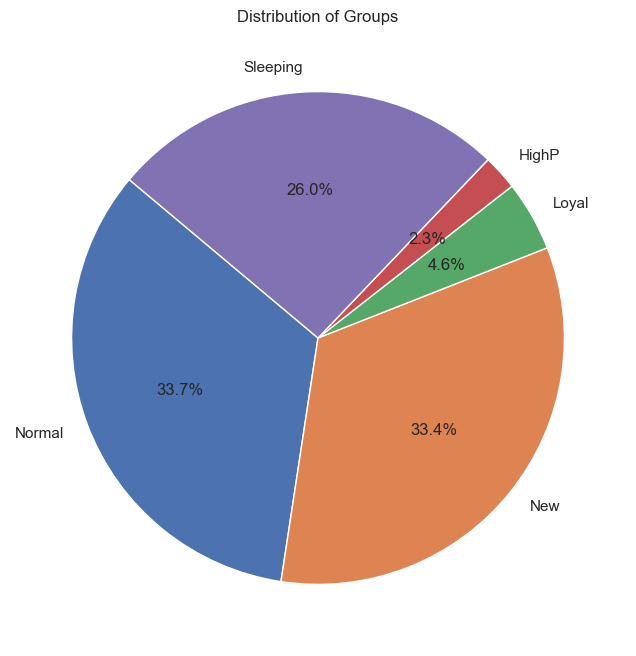

In [52]:
cluster_group_count = cluster.groupby('group').size() 
cluster_group_count
plt.figure(figsize=(8, 8))
plt.pie(cluster_group_count, labels=cluster_group_count.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Groups')
plt.show()

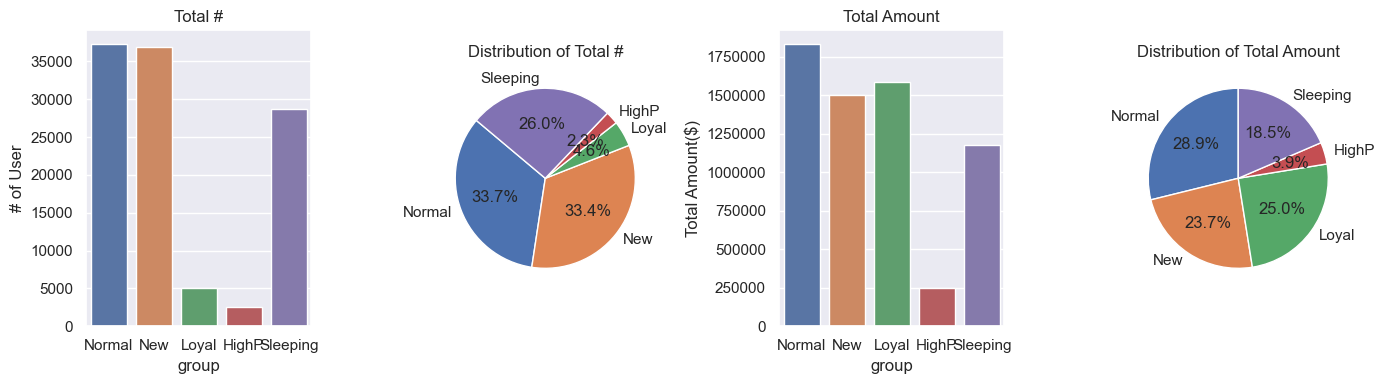

In [53]:
group_amount = cluster.groupby('group')['amount'].sum().reset_index()
group_count = cluster.groupby('group').size()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 4))
#Bar plot
sns.barplot(x=group_count.index, y=group_count, ax=ax1)
ax1.set_ylabel('# of User')
ax1.set_title('Total #')
ax1.ticklabel_format(style='plain', axis='y')  # 禁用y軸ㄉ科學記號

#Pie Chart
ax2.pie(cluster_group_count, labels=cluster_group_count.index, autopct='%1.1f%%', startangle=140)
ax2.set_title('Distribution of Total #')

#Bar plot
sns.barplot(x='group', y='amount', data=group_amount, ax=ax3)
ax3.set_ylabel('Total Amount($)')
ax3.set_title('Total Amount')
ax3.ticklabel_format(style='plain', axis='y')  # 禁用y軸科學記號

#Pie Chart
ax4.pie(group_amount['amount'], labels= group_amount['group'], autopct='%1.1f%%', startangle= 90)
ax4.set_title('Distribution of Total Amount')

plt.tight_layout()
plt.show()

這邊可以看見雖然忠誠顧客的人數並不多，但貢獻了非常多銷售額。  
高購買力顧客的銷售額占比也遠高於人數占比，也是值得注意的一個族群。  

In [54]:
group_info = pd.concat([group_amount.set_index('group'), group_count.rename('user_count')], axis= 1)
# 計算人均貢獻消費額
group_info['avg_contribution'] = group_info['amount'] / group_info['user_count']
group_info

,amount,user_count,avg_contribution
group,,,
Normal,1831637.470,37255,49.165
New,1501834.640,36877,40.726
Loyal,1589657.330,5091,312.249
HighP,248288.390,2548,97.444
Sleeping,1176471.520,28747,40.925


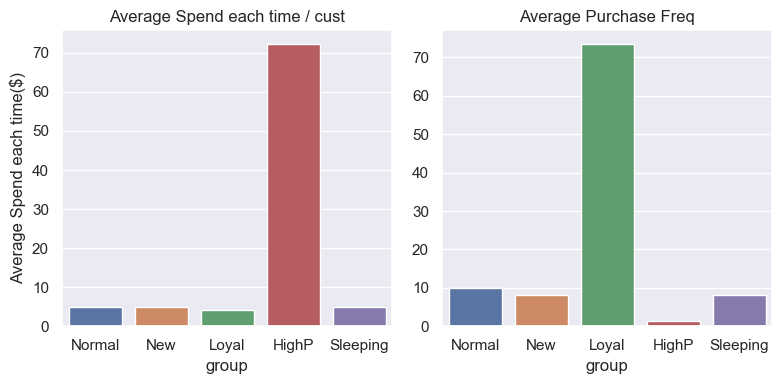

In [55]:
group_mean = cluster.groupby('group')['amount'].sum() / cluster.groupby('group')['purchase_count'].sum()
group_freq = cluster.groupby('group')['purchase_count'].sum() / cluster_group_count

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
#Bar plot
sns.barplot(x=group_mean.index, y= group_mean.values, ax= ax1)
ax1.set_ylabel('Average Spend each time($)')
ax1.set_title('Average Spend each time / cust')

sns.barplot(x=group_freq.index, y=group_freq, ax=ax2)
ax2.set_title('Average Purchase Freq')

plt.tight_layout()
plt.show()

承上分析，  
- 高購買力顧客平均每次消費額遠超其他族群，但頻率明顯最低  
- 忠誠顧客的平均消費頻率遠超其他族群  


In [56]:
group_info['avg_buying_amount']  = group_mean.values
group_info['avg_freq'] = group_freq.values
group_info.reset_index(inplace= True)

group_info

,group,amount,user_count,avg_contribution,avg_buying_amount,avg_freq
0,Normal,1831637.470,37255,49.165,4.956,9.920
1,New,1501834.640,36877,40.726,4.970,8.194
2,Loyal,1589657.330,5091,312.249,4.255,73.376
3,HighP,248288.390,2548,97.444,72.135,1.351
4,Sleeping,1176471.520,28747,40.925,4.959,8.252


看看各個集群的行為特點。

In [57]:
#在原先的data上根據user_id加入分群資訊，阿沒有被貼到的那些(代表沒消費過)就捨棄
user_group_dict = dict(zip(cluster['user_id'], cluster['group']))
data['group'] = data['user_id'].map(user_group_dict)
cluster_data = data.dropna(subset=['group'])

cluster_data.head()

,event_time,event_type,product_id,category_id,brand,price,user_id,date,month,day,weekday,hr,group
0,2019-10-01 00:00:00,cart,5773203,1487580005134238553,runail,2.620,463240011,2019-10-01,Oct 2019,1,Tuesday,0,Sleeping
1,2019-10-01 00:00:03,cart,5773353,1487580005134238553,runail,2.620,463240011,2019-10-01,Oct 2019,1,Tuesday,0,Sleeping
2,2019-10-01 00:00:07,cart,5723490,1487580005134238553,runail,2.620,463240011,2019-10-01,Oct 2019,1,Tuesday,0,Sleeping
3,2019-10-01 00:00:07,cart,5881589,2151191071051219817,lovely,13.480,429681830,2019-10-01,Oct 2019,1,Tuesday,0,Sleeping
4,2019-10-01 00:00:15,cart,5881449,1487580013522845895,lovely,0.560,429681830,2019-10-01,Oct 2019,1,Tuesday,0,Sleeping


In [58]:
cluster_data['user_id'].nunique()

110518

user一樣是110518位沒錯，可以看到它們留下一千多萬筆有消費記錄的行為紀錄，接著我們一樣來分析時間，但依照各個族群來分析。

In [59]:
#做好前置準備，篩出各族群資料
group_list = ['Normal', 'New', 'Loyal', 'HighP', 'Sleeping']
normal_data = cluster_data[cluster_data['group'] == 'Normal']
new_data = cluster_data[cluster_data['group'] == 'New']
loyal_data = cluster_data[cluster_data['group'] == 'Loyal']
highp_data = cluster_data[cluster_data['group'] == 'HighP']
sleeping_data = cluster_data[cluster_data['group'] == 'Sleeping']

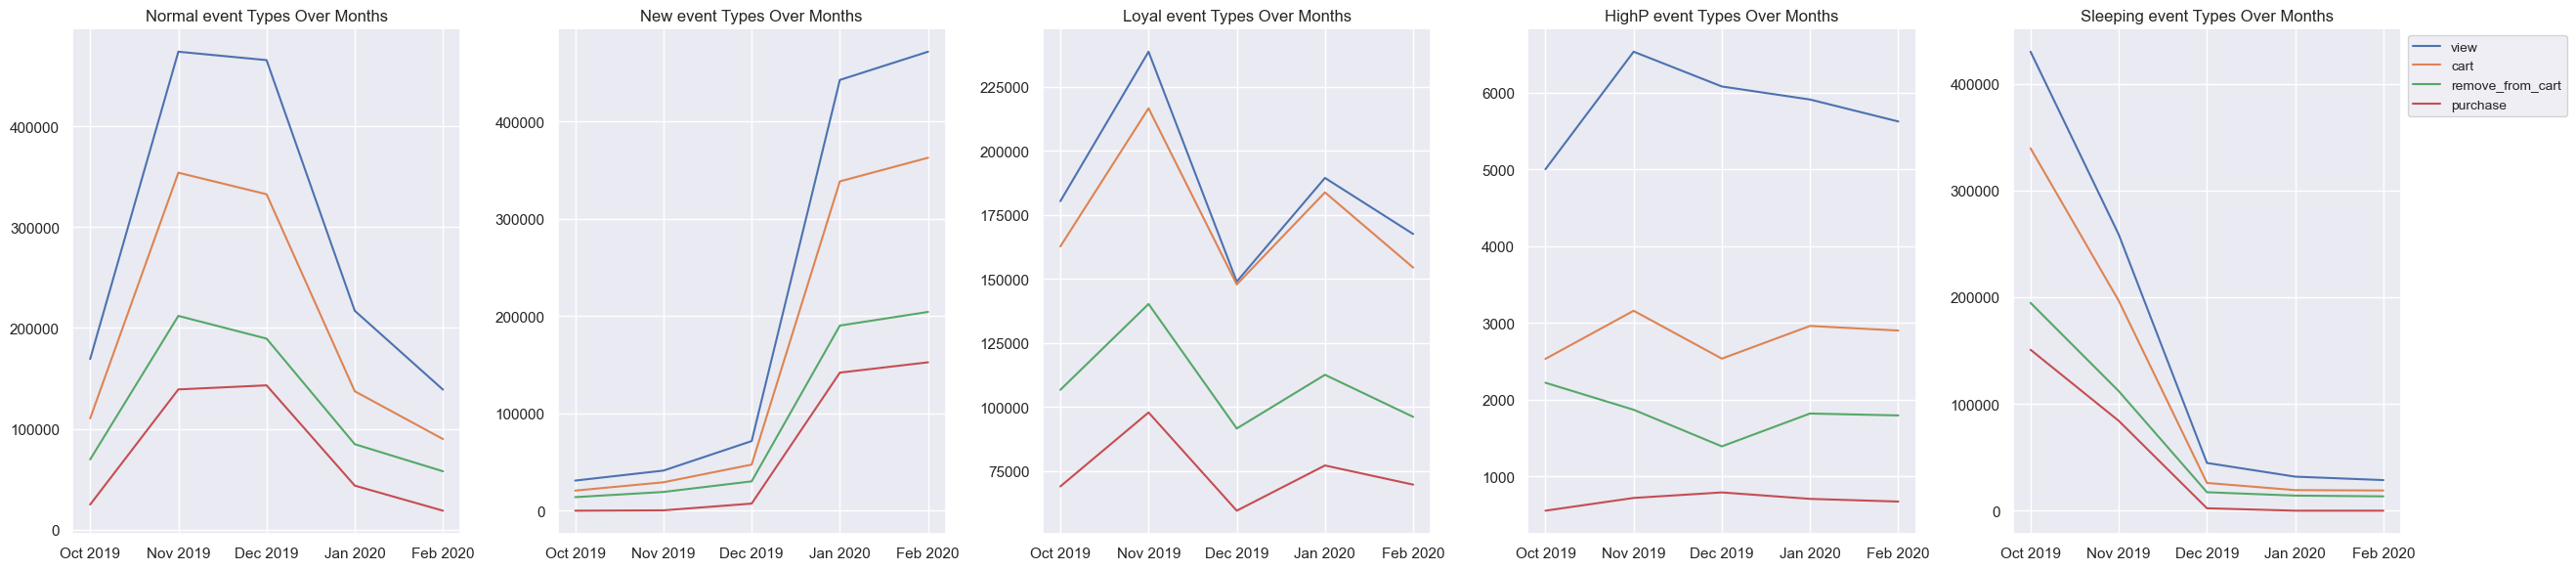

In [60]:
fig, axes = plt.subplots(1, 5, figsize= (25,6))

#先處理資料
for i, group in enumerate(group_list):
    group_data = cluster_data[cluster_data['group'] == group]
    group_event_by_month = group_data.groupby('month')['event_type'].value_counts().unstack()
    
    #然後畫圖
    for column in group_event_by_month.columns:
        axes[i].plot(group_event_by_month.index, group_event_by_month[column], label= column)
    # 對每張子圖弄標籤&標題
    axes[i].set_title(f'{group} event Types Over Months', fontsize= 12)
    axes[i].ticklabel_format(style= 'plain', axis= 'y')  # 禁用y軸ㄉ科學記號


plt.tight_layout()
plt.legend(loc= 'upper left', bbox_to_anchor= (1, 1), fontsize= 10)
plt.show()

相當符合前述群集特色
- 新進顧客的消費者行為隨時間成長，距今越近越活躍
- 沉睡顧客的消費者行為隨時間減少，距今越遠越活躍

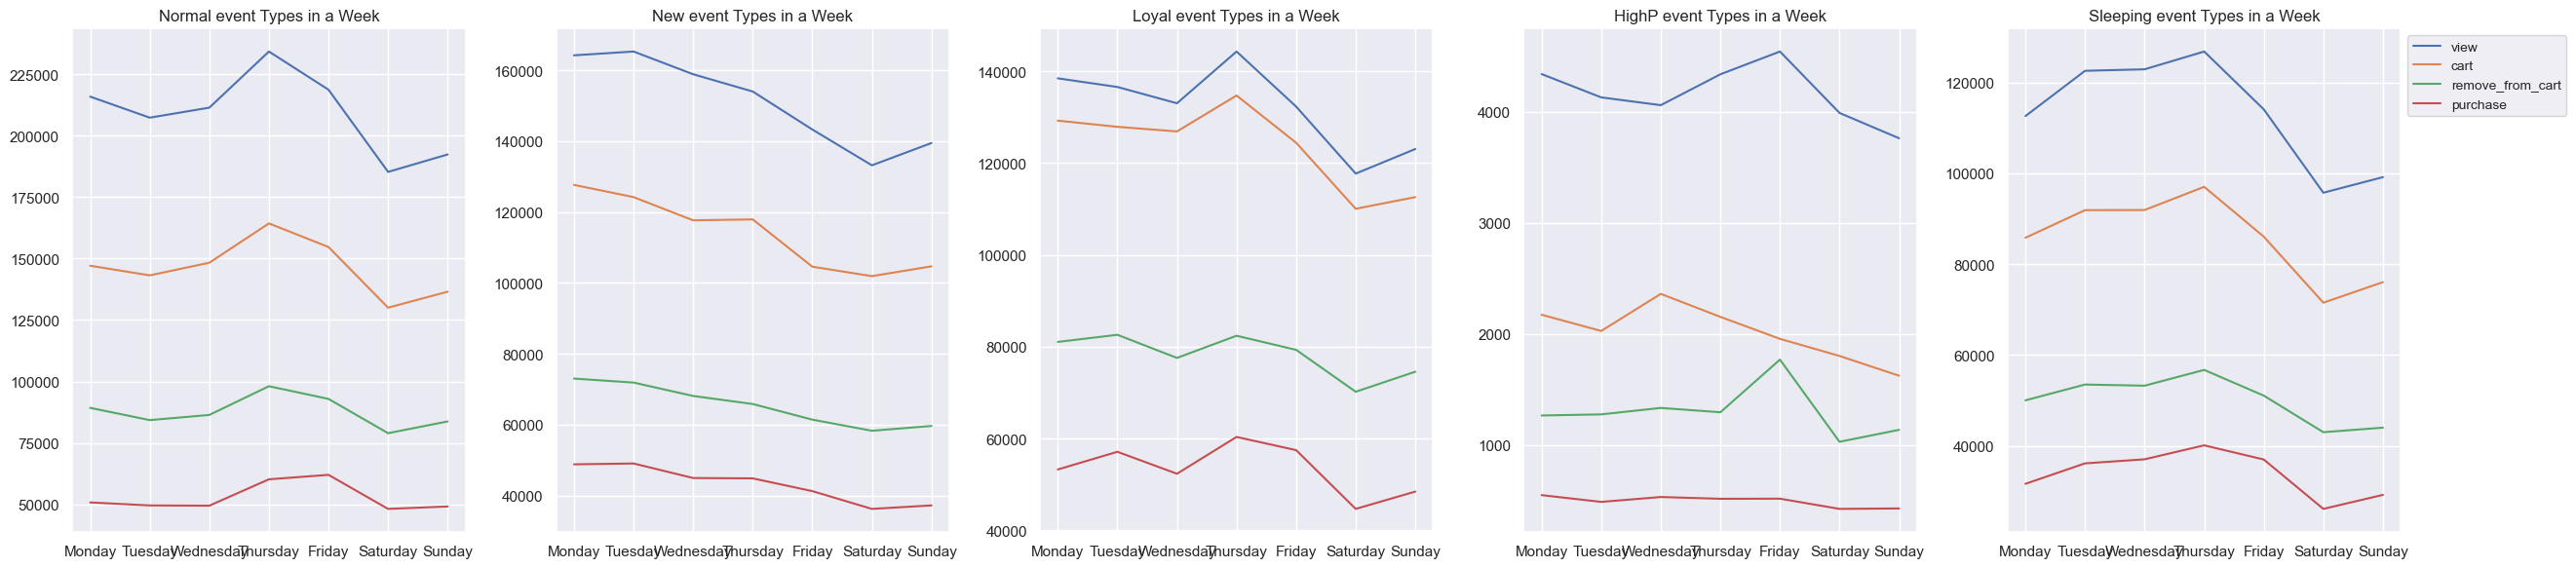

In [61]:
fig, axes = plt.subplots(1, 5, figsize= (25,6))

# 先處理資料
for i, group in enumerate(group_list):
    group_data = cluster_data[cluster_data['group'] == group]
    event_by_weekday = group_data.groupby('weekday')['event_type'].value_counts().unstack()
    #然後畫圖
    for column in event_by_weekday.columns:
        axes[i].plot(event_by_weekday.index, event_by_weekday[column], label= column)
    axes[i].set_title(f'{group} event Types in a Week', fontsize= 12)
    axes[i].ticklabel_format(style= 'plain', axis= 'y')  #禁用y軸ㄉ科學記號
    axes[i].grid(True)

plt.tight_layout()
plt.legend(loc= 'upper left', bbox_to_anchor= (1, 1), fontsize= 10)
plt.show()

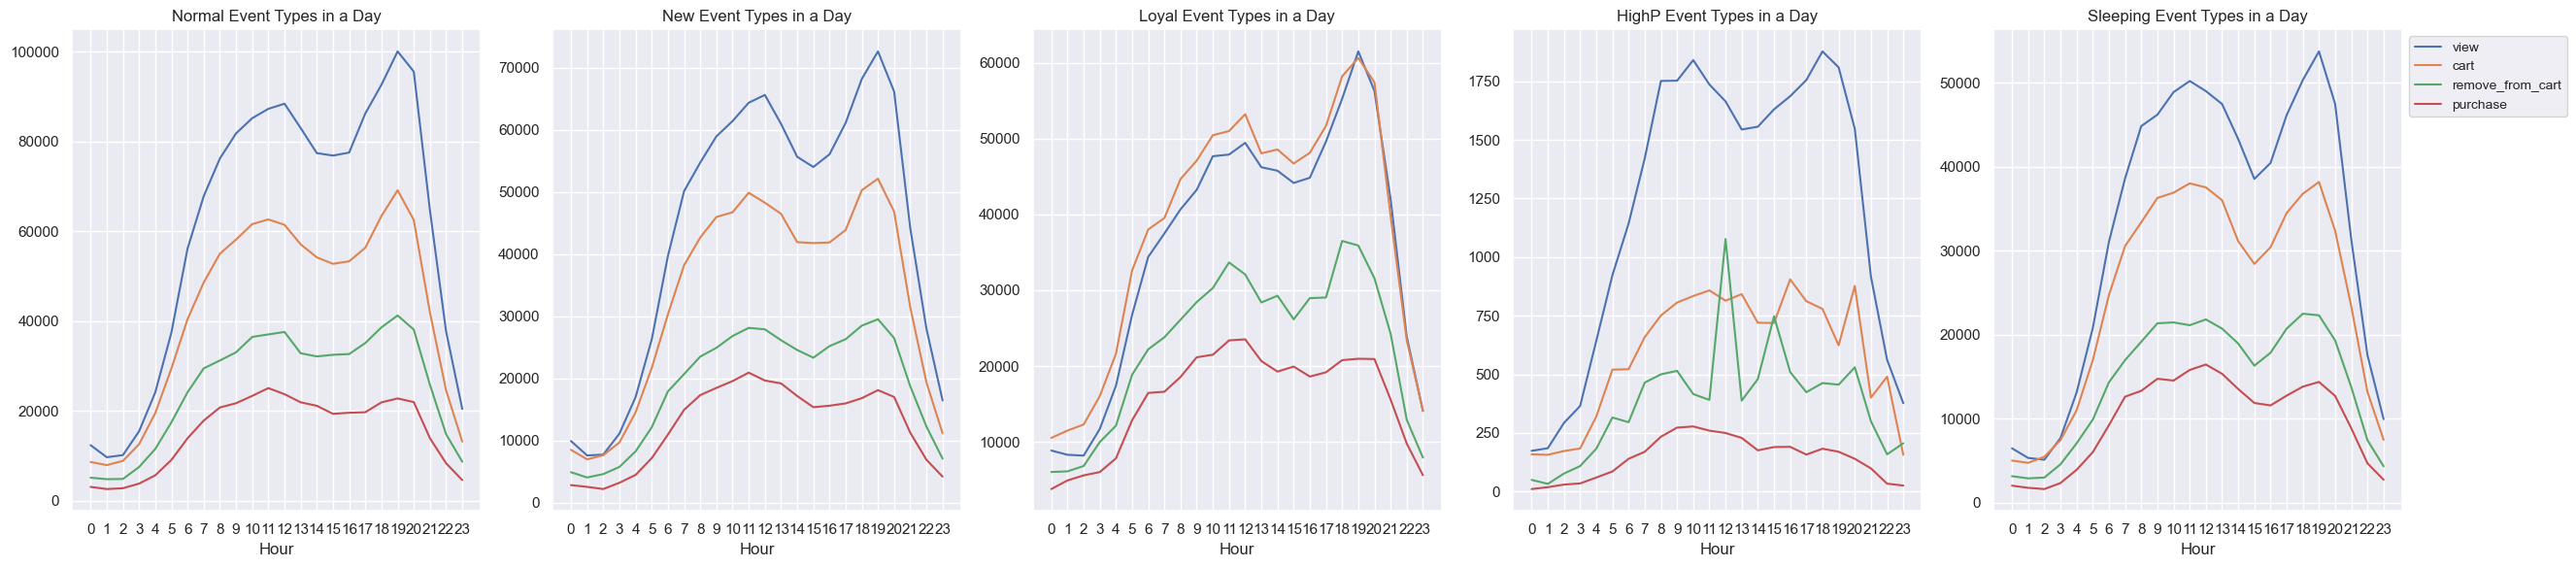

In [62]:
fig, axes = plt.subplots(1, 5, figsize= (25, 6))

# 先處理資料
for i, group in enumerate(group_list):
    group_data = cluster_data[cluster_data['group'] == group]
    event_by_hour = group_data.groupby('hr')['event_type'].value_counts().unstack()
    #然後畫圖
    for column in event_by_hour.columns:
        axes[i].plot(event_by_hour.index, event_by_hour[column], label=column)
    axes[i].set_title(f'{group} Event Types in a Day', fontsize= 12)
    axes[i].set_xlabel('Hour')
    axes[i].set_xticks(event_by_hour.index)
    axes[i].ticklabel_format(style='plain', axis= 'y')  #禁用y軸ㄉ科學記號
    axes[i].grid(True)

plt.tight_layout()
plt.legend(loc= 'upper left', bbox_to_anchor= (1, 1), fontsize= 10)
plt.show()


透過這個分析，可以摸清楚各族群各種行為與時間的關係。   
從月份來看，新進顧客和沉睡顧客基本上符合它們的族群定義，新進顧客的行為都發生於近期，沉睡顧客則反之。其他幾群的特徵則與總體大致相符，尖峰期都在11月。
從其他級別來看各有特色，但基本上也和總體趨勢相去不遠。

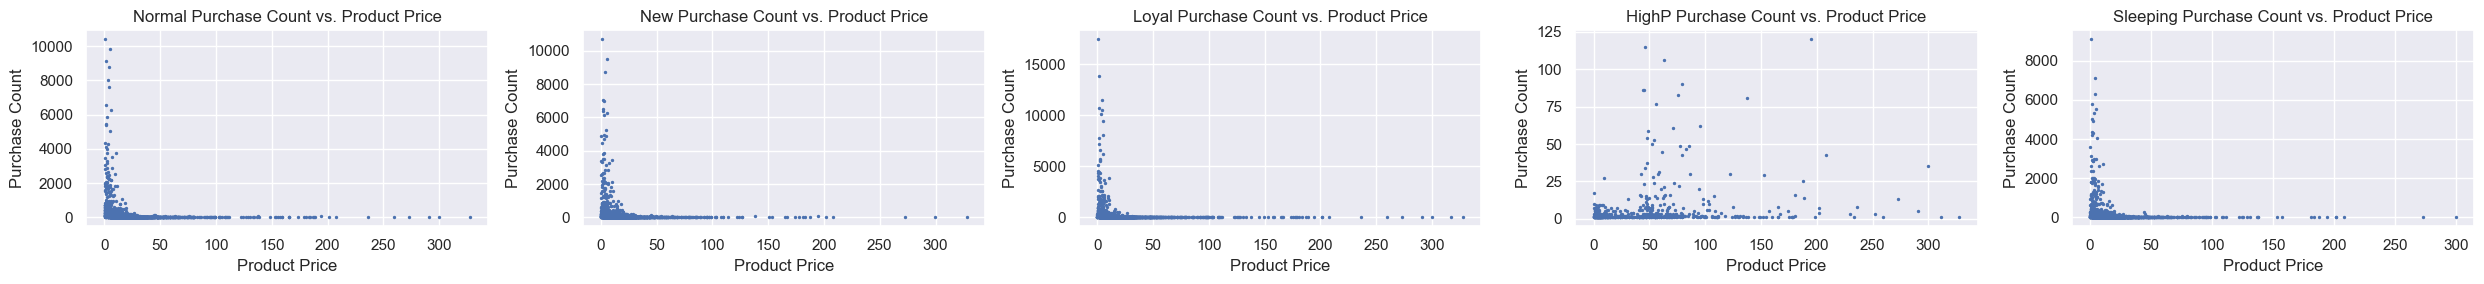

In [64]:
#Product_price and Frequency

fig, axes = plt.subplots(1, 5, figsize= (25,3))

for i, group in enumerate(group_list):
    group_data = cluster_data[cluster_data['group'] == group]
    purchase_count = group_data[group_data['event_type'] == 'purchase']['price'].value_counts().sort_index()
    axes[i].scatter(purchase_count.index, purchase_count.values, s= 2)
    axes[i].set_title(f'{group} Purchase Count vs. Product Price')
    axes[i].set_xlabel('Product Price')
    axes[i].set_ylabel('Purchase Count')

plt.tight_layout()
plt.show()

高購買力顧客確實會比較會買高單價商品。

### 有一群被忽略的......

In [65]:
#看看紀錄中完全沒有purchase紀錄的人們
non_purchase_user_data = user_data[user_data['purchase_count']== 0]
non_purchase_user_data.describe()

,user_id,view_count,cart_count,remove_from_cart_count,purchase_count,amount
count,1528840.000,1528840.000,1528840.000,1528840.000,1528840.000,1528840.000
mean,560103541.533,3.556,1.497,0.658,0.000,0.000
std,63429092.649,23.191,11.341,9.080,0.000,0.000
min,465496.000,0.000,0.000,0.000,0.000,0.000
25%,556031436.000,1.000,0.000,0.000,0.000,0.000
50%,574024280.500,1.000,0.000,0.000,0.000,0.000
75%,599170920.750,3.000,0.000,0.000,0.000,0.000
max,622090237.000,20480.000,3665.000,2727.000,0.000,0.000


In [66]:
non_purchase_user_data.nunique()

user_id                   1528840
view_count                    512
cart_count                    446
remove_from_cart_count        395
purchase_count                  1
amount                          1
dtype: int64

將客戶的分群貼回原本的data，至於那些沒有消費的就當成一個叫做Others的族群。   
最後我們將他輸出成CSV。

In [67]:
final_data = data.copy()
group_mapping = dict(zip(cluster['user_id'], cluster['group']))
final_data['group'] = final_data['user_id'].map(group_mapping)
final_data['group'].fillna('Others', inplace=True)
final_data.head()

,event_time,event_type,product_id,category_id,brand,price,user_id,date,month,day,weekday,hr,group
0,2019-10-01 00:00:00,cart,5773203,1487580005134238553,runail,2.620,463240011,2019-10-01,Oct 2019,1,Tuesday,0,Sleeping
1,2019-10-01 00:00:03,cart,5773353,1487580005134238553,runail,2.620,463240011,2019-10-01,Oct 2019,1,Tuesday,0,Sleeping
2,2019-10-01 00:00:07,cart,5723490,1487580005134238553,runail,2.620,463240011,2019-10-01,Oct 2019,1,Tuesday,0,Sleeping
3,2019-10-01 00:00:07,cart,5881589,2151191071051219817,lovely,13.480,429681830,2019-10-01,Oct 2019,1,Tuesday,0,Sleeping
4,2019-10-01 00:00:15,cart,5881449,1487580013522845895,lovely,0.560,429681830,2019-10-01,Oct 2019,1,Tuesday,0,Sleeping


In [68]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19571767 entries, 0 to 19571766
Data columns (total 13 columns):
 #   Column       Dtype         
---  ------       -----         
 0   event_time   datetime64[ns]
 1   event_type   category      
 2   product_id   int64         
 3   category_id  int64         
 4   brand        object        
 5   price        float64       
 6   user_id      int64         
 7   date         datetime64[ns]
 8   month        category      
 9   day          int64         
 10  weekday      category      
 11  hr           int64         
 12  group        object        
dtypes: category(3), datetime64[ns](2), float64(1), int64(5), object(2)
memory usage: 1.5+ GB


In [69]:
final_data.shape

(19571767, 13)

In [70]:
final_data.to_csv("final_data.csv", index= False)